In [1]:
!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.5 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=0e52002675ef742d745de27fd211c6274ef9094529dfff211f8075c29ccbd1d7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8bfc29a623365b4afc216684bb5bd99cb3b96e6499acd99354112c6a11e13a26
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [151]:
import zipfile
import random
import os
import json
import numpy as np
import cv2
from sklearn.metrics import f1_score, roc_auc_score
import torchvision
import torch
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image,ImageColor
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset
from torchvision.models.segmentation.deeplabv3 import DeepLabHead,deeplabv3_mobilenet_v3_large
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from skimage.draw import polygon
from torchvision import transforms
from torch import nn
from segmentation_models_pytorch import MAnet
from  segmentation_models_pytorch.losses import DiceLoss,JaccardLoss
from segmentation_models_pytorch.metrics import get_stats,iou_score,f1_score

In [3]:
carparts_imgs = "/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/img/"
carparts_anns = "/kaggle/input/car-parts-and-car-damages/Car damages dataset/File1/ann/"
sizes=(320,320)

In [4]:
def retrieve_meta_data(path="/kaggle/input/car-parts-and-car-damages/Car damages dataset/meta.json"):
    MetaJson = json.load(open(path,"r"))
    classes_carprts = []
    associated_colors_carprts = []
    for cls in MetaJson["classes"]:
        classes_carprts.append(cls["title"])
        associated_colors_carprts.append(cls['id'])
    return classes_carprts,associated_colors_carprts

In [5]:
class CarDataLoader(Dataset):
    def __init__(self,transforms,imgs_path,annotations_path,classes,sizes):
        self.imgs_path =imgs_path
        self.annotations_path = annotations_path
        self.classes = classes
        self.images = list(sorted(os.listdir(imgs_path)))
        self.annotations = [x+".json" for x in self.images]
        self.transforms = transforms
        self.sizes = sizes
    
    def getMask(sizes,annfile,classes):
        img_height,img_width = annfile["size"]["height"],annfile["size"]["width"]
        mask = torch.zeros((img_height,img_width),dtype=torch.long)
        mask_numpy = mask.numpy()
        class_ids =[]
        for object_ in annfile["objects"]:
            class_id = classes.index(object_["classId"])
            class_ids.append(class_id)
            polygon_ = []
            for i in object_["points"]["exterior"]:
                polygon_.append(i)
            polygon_ = np.asarray(polygon_)
            x_,y_ = polygon(polygon_[:,0],polygon_[:,1],(annfile["size"]["width"],annfile["size"]["height"])) 
            mask_numpy[y_,x_] = class_id+1

        mask_tensor = transforms.Resize(sizes)(torch.from_numpy(mask_numpy).unsqueeze(0)).squeeze(1)
        mask_numpy = mask_tensor.numpy()
        masks = [(mask_numpy  == class_id) for class_id in range(len(classes)+1)]
        masks_numpy = np.stack(masks,axis=-1).astype('int')
        return masks_numpy
                

    def __getitem__(self,idx):
        img_path = os.path.join(self.imgs_path, self.images[idx])
        ann_path = os.path.join(self.annotations_path, self.annotations[idx])
        img = Image.open(img_path)
        ann = json.load(open(ann_path,"r"))

        annotated_mask = CarDataLoader.getMask(self.sizes,ann,self.classes)
        img_tensor = self.transforms(img)[:3,:,:]
        mask_tensor = torch.from_numpy(annotated_mask).permute(0,-1,1,2)

        return img_tensor,mask_tensor
    def __len__(self):
        return len(self.images)

In [6]:
CarPartsClasses,CarPartsClasses_ID = retrieve_meta_data("/kaggle/input/car-parts-and-car-damages/Car damages dataset/meta.json")

In [7]:
transform = transforms.Compose([transforms.Resize(sizes),
    transforms.ToTensor()])


In [8]:
CarPartsData =  CarDataLoader(transform,carparts_imgs,carparts_anns,CarPartsClasses_ID,sizes)

In [113]:
image,mask = CarPartsData[0]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


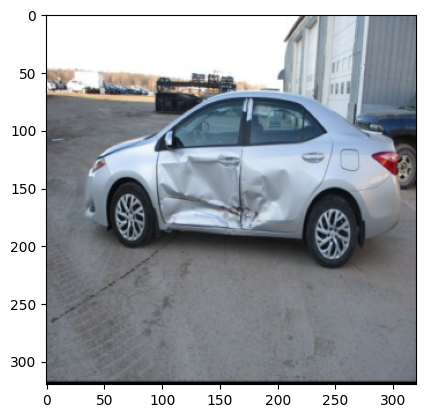

In [114]:
plt.imshow(image.permute(1,2,0))

In [11]:
mask.shape

torch.Size([1, 22, 320, 320])

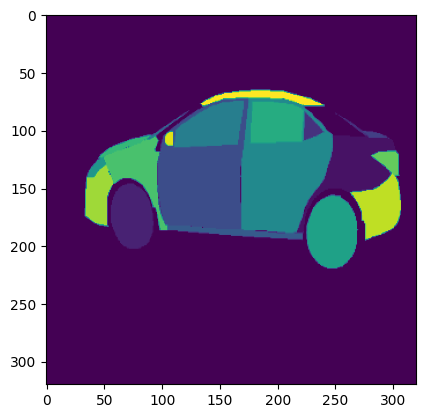

In [115]:
plt.imshow(mask.squeeze(0).argmax(dim=0))

In [13]:
mask.min(),mask.max()

(tensor(0), tensor(1))

In [111]:
def visualizeImageandMasks(image,output,target):

    col = 3
    row = 1
    fig, ax = plt.subplots(row,col)
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[1].imshow(output)
    ax[1].set_title("Output")
    ax[2].imshow(target)
    ax[2].set_title("Target")
    plt.show()
    

In [14]:
len(CarPartsClasses_ID)+1

22

In [15]:
dataloader = DataLoader(CarPartsData,batch_size=20,shuffle=True)

In [16]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [17]:
device

'cuda'

In [155]:
def TrainandValidate(model,optim,criterion,dataloader,learning_rate,epochs,checkpointName,classes,checkpoint=True):
    """
    For training and Validating Segmentation models
    model [nn.Module]  ->   Model to Train
    optim     ->     Optimizer
    criterion -> Loss Function
    """
    # Training Loop
    for epoch in range(epochs):
        loop = tqdm(enumerate(dataloader), total=len(dataloader))  # Progress bar
        for batch_idx, (data, targets) in loop:
            if batch_idx +5 < len(dataloader):
                model.train()
                targets = targets.squeeze(1)
                data, targets = data.to(device), targets.to(device)

                # Forward Pass
                outputs = model(data)

                tp, fp, fn, tn = get_stats(outputs.int(), targets.int(), mode="multilabel",threshold=0.5)
                iouscore = iou_score(tp, fp, fn, tn, reduction="micro")

                # Loss Calculation
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loop.set_description(f'Epoch {epoch+1}/{epochs}')
                loop.set_postfix(loss=loss.item(),iou_score = iouscore.item())

            else:
                model.eval()
                targets = targets.squeeze(1)
                data, targets = data.to(device), targets.to(device)

                # Forward Pass
                outputs = model(data)
                tp, fp, fn, tn = get_stats(outputs.int(), targets.int(), mode='multilabel',threshold=0.5)
                iouscore = iou_score(tp, fp, fn, tn, reduction="micro")

                # Loss Calculation
                loss = criterion(outputs, targets.long())  # Ensure targets are long type
                
                print(f" Epoch under Validation {batch_idx}, Loss: {loss.item()}, IOUScore {iouscore.item()}")
                #loop.set_description(f'Epoch {epoch+1}/{epochs}')
                #loop.set_postfix(loss=loss.item(),iou_score = iouscore.item())
        if epoch%10 == 0:
            # Save Checkpoint
            torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                'iou_score': iou_score
                    }, f"checkpoint_{checkpointName}{epoch+1}.pth")

## Dice Loss

Dice loss, also known as the Sørensen-Dice coefficient or Dice's coefficient, is a statistical tool that measures the similarity between two datasets. It is defined as the ratio of the size of the intersection to the size of the union of two datasets: 2TP / (2TP + FP + FN) where TP is the number of true positives, FP is the number of false positives, and FN is the number of false negatives. Dice loss is a measure of dissimilarity between two datasets, and it ranges from 0 (denoting total dissimilarity) to 1 (denoting perfect similarity).


In [19]:
learning_rate = 0.0001
epochs = 50

# Model, Loss, and Optimizer
model = MAnet(classes = len(CarPartsClasses_ID)+1,encoder_weights="imagenet")
model.to(device)
criterion = DiceLoss(classes = len(CarPartsClasses_ID)+1,mode="multilabel")

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

TrainandValidate(model,optimizer,criterion,dataloader,learning_rate,epochs,"MAnet",classes = len(CarPartsClasses_ID)+1)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 205MB/s] 
Epoch 1/50:  92%|█████████▏| 46/50 [03:26<00:17,  4.50s/it, iou_score=0.222, loss=0.906] 

 Epoch under Validation 45, Loss: 0.9026524424552917, IOUScore 0.18858154118061066


Epoch 1/50:  94%|█████████▍| 47/50 [03:31<00:13,  4.43s/it, iou_score=0.222, loss=0.906]

 Epoch under Validation 46, Loss: 0.9036957621574402, IOUScore 0.1991771161556244


Epoch 1/50:  96%|█████████▌| 48/50 [03:35<00:08,  4.42s/it, iou_score=0.222, loss=0.906]

 Epoch under Validation 47, Loss: 0.8991486430168152, IOUScore 0.1804557591676712


Epoch 1/50:  98%|█████████▊| 49/50 [03:39<00:04,  4.26s/it, iou_score=0.222, loss=0.906]

 Epoch under Validation 48, Loss: 0.9028310179710388, IOUScore 0.20533297955989838


Epoch 1/50: 100%|██████████| 50/50 [03:42<00:00,  4.46s/it, iou_score=0.222, loss=0.906]

 Epoch under Validation 49, Loss: 0.9016080498695374, IOUScore 0.2010563313961029



Epoch 2/50:  92%|█████████▏| 46/50 [02:45<00:14,  3.55s/it, iou_score=0.334, loss=0.884]

 Epoch under Validation 45, Loss: 0.8862918019294739, IOUScore 0.33996203541755676


Epoch 2/50:  94%|█████████▍| 47/50 [02:49<00:10,  3.50s/it, iou_score=0.334, loss=0.884]

 Epoch under Validation 46, Loss: 0.8881260752677917, IOUScore 0.34182584285736084


Epoch 2/50:  96%|█████████▌| 48/50 [02:52<00:07,  3.55s/it, iou_score=0.334, loss=0.884]

 Epoch under Validation 47, Loss: 0.8856052160263062, IOUScore 0.3495573401451111


Epoch 2/50:  98%|█████████▊| 49/50 [02:56<00:03,  3.51s/it, iou_score=0.334, loss=0.884]

 Epoch under Validation 48, Loss: 0.8920144438743591, IOUScore 0.3338055908679962


Epoch 2/50: 100%|██████████| 50/50 [02:59<00:00,  3.59s/it, iou_score=0.334, loss=0.884]

 Epoch under Validation 49, Loss: 0.888237714767456, IOUScore 0.32527682185173035



Epoch 3/50:  92%|█████████▏| 46/50 [02:47<00:14,  3.65s/it, iou_score=0.343, loss=0.876]

 Epoch under Validation 45, Loss: 0.8695306777954102, IOUScore 0.3444674015045166


Epoch 3/50:  94%|█████████▍| 47/50 [02:51<00:10,  3.65s/it, iou_score=0.343, loss=0.876]

 Epoch under Validation 46, Loss: 0.8702095746994019, IOUScore 0.3448130190372467


Epoch 3/50:  96%|█████████▌| 48/50 [02:54<00:06,  3.50s/it, iou_score=0.343, loss=0.876]

 Epoch under Validation 47, Loss: 0.8738328814506531, IOUScore 0.36641499400138855


Epoch 3/50:  98%|█████████▊| 49/50 [02:57<00:03,  3.42s/it, iou_score=0.343, loss=0.876]

 Epoch under Validation 48, Loss: 0.8702853918075562, IOUScore 0.36422625184059143


Epoch 3/50: 100%|██████████| 50/50 [03:00<00:00,  3.62s/it, iou_score=0.343, loss=0.876]

 Epoch under Validation 49, Loss: 0.8713030815124512, IOUScore 0.3505888283252716



Epoch 4/50:  92%|█████████▏| 46/50 [02:45<00:14,  3.52s/it, iou_score=0.352, loss=0.849]

 Epoch under Validation 45, Loss: 0.8610373735427856, IOUScore 0.35748621821403503


Epoch 4/50:  94%|█████████▍| 47/50 [02:48<00:10,  3.35s/it, iou_score=0.352, loss=0.849]

 Epoch under Validation 46, Loss: 0.8543741106987, IOUScore 0.34894388914108276


Epoch 4/50:  96%|█████████▌| 48/50 [02:51<00:06,  3.30s/it, iou_score=0.352, loss=0.849]

 Epoch under Validation 47, Loss: 0.8530946373939514, IOUScore 0.3372979462146759


Epoch 4/50:  98%|█████████▊| 49/50 [02:55<00:03,  3.36s/it, iou_score=0.352, loss=0.849]

 Epoch under Validation 48, Loss: 0.8495457768440247, IOUScore 0.33496949076652527


Epoch 4/50: 100%|██████████| 50/50 [02:58<00:00,  3.56s/it, iou_score=0.352, loss=0.849]

 Epoch under Validation 49, Loss: 0.8514643907546997, IOUScore 0.36311739683151245



Epoch 5/50:  92%|█████████▏| 46/50 [02:47<00:13,  3.42s/it, iou_score=0.384, loss=0.826]

 Epoch under Validation 45, Loss: 0.8393856883049011, IOUScore 0.43701818585395813


Epoch 5/50:  94%|█████████▍| 47/50 [02:51<00:10,  3.47s/it, iou_score=0.384, loss=0.826]

 Epoch under Validation 46, Loss: 0.8317945003509521, IOUScore 0.39697083830833435


Epoch 5/50:  96%|█████████▌| 48/50 [02:54<00:06,  3.37s/it, iou_score=0.384, loss=0.826]

 Epoch under Validation 47, Loss: 0.8379403948783875, IOUScore 0.3962126076221466


Epoch 5/50:  98%|█████████▊| 49/50 [02:58<00:03,  3.40s/it, iou_score=0.384, loss=0.826]

 Epoch under Validation 48, Loss: 0.8352394104003906, IOUScore 0.3909984230995178


Epoch 5/50: 100%|██████████| 50/50 [03:00<00:00,  3.62s/it, iou_score=0.384, loss=0.826]

 Epoch under Validation 49, Loss: 0.838607132434845, IOUScore 0.4091590344905853



Epoch 6/50:  92%|█████████▏| 46/50 [02:45<00:13,  3.32s/it, iou_score=0.398, loss=0.819]

 Epoch under Validation 45, Loss: 0.8103145360946655, IOUScore 0.4241924285888672


Epoch 6/50:  94%|█████████▍| 47/50 [02:49<00:10,  3.52s/it, iou_score=0.398, loss=0.819]

 Epoch under Validation 46, Loss: 0.8087998628616333, IOUScore 0.3845656216144562


Epoch 6/50:  96%|█████████▌| 48/50 [02:52<00:06,  3.43s/it, iou_score=0.398, loss=0.819]

 Epoch under Validation 47, Loss: 0.8175938725471497, IOUScore 0.40111225843429565


Epoch 6/50:  98%|█████████▊| 49/50 [02:56<00:03,  3.56s/it, iou_score=0.398, loss=0.819]

 Epoch under Validation 48, Loss: 0.8110772967338562, IOUScore 0.3928956687450409


Epoch 6/50: 100%|██████████| 50/50 [03:00<00:00,  3.60s/it, iou_score=0.398, loss=0.819]

 Epoch under Validation 49, Loss: 0.8058987855911255, IOUScore 0.3683929443359375



Epoch 7/50:  92%|█████████▏| 46/50 [02:46<00:14,  3.61s/it, iou_score=0.408, loss=0.789]

 Epoch under Validation 45, Loss: 0.7918315529823303, IOUScore 0.4135369658470154


Epoch 7/50:  94%|█████████▍| 47/50 [02:50<00:11,  3.69s/it, iou_score=0.408, loss=0.789]

 Epoch under Validation 46, Loss: 0.7803077697753906, IOUScore 0.40870290994644165


Epoch 7/50:  96%|█████████▌| 48/50 [02:53<00:07,  3.70s/it, iou_score=0.408, loss=0.789]

 Epoch under Validation 47, Loss: 0.7750344276428223, IOUScore 0.40843287110328674


Epoch 7/50:  98%|█████████▊| 49/50 [02:57<00:03,  3.59s/it, iou_score=0.408, loss=0.789]

 Epoch under Validation 48, Loss: 0.7951205968856812, IOUScore 0.4158928394317627


Epoch 7/50: 100%|██████████| 50/50 [03:00<00:00,  3.60s/it, iou_score=0.408, loss=0.789]

 Epoch under Validation 49, Loss: 0.7893968224525452, IOUScore 0.4487312436103821



Epoch 8/50:  92%|█████████▏| 46/50 [02:49<00:13,  3.47s/it, iou_score=0.479, loss=0.744]

 Epoch under Validation 45, Loss: 0.7553231716156006, IOUScore 0.45866963267326355


Epoch 8/50:  94%|█████████▍| 47/50 [02:52<00:10,  3.38s/it, iou_score=0.479, loss=0.744]

 Epoch under Validation 46, Loss: 0.7636218070983887, IOUScore 0.4395904839038849


Epoch 8/50:  96%|█████████▌| 48/50 [02:55<00:06,  3.40s/it, iou_score=0.479, loss=0.744]

 Epoch under Validation 47, Loss: 0.7458922863006592, IOUScore 0.4448379576206207


Epoch 8/50:  98%|█████████▊| 49/50 [02:59<00:03,  3.44s/it, iou_score=0.479, loss=0.744]

 Epoch under Validation 48, Loss: 0.7579593658447266, IOUScore 0.4160844385623932


Epoch 8/50: 100%|██████████| 50/50 [03:02<00:00,  3.64s/it, iou_score=0.479, loss=0.744]

 Epoch under Validation 49, Loss: 0.765701949596405, IOUScore 0.4412038326263428



Epoch 9/50:  92%|█████████▏| 46/50 [02:45<00:14,  3.51s/it, iou_score=0.53, loss=0.712] 

 Epoch under Validation 45, Loss: 0.7252252697944641, IOUScore 0.48358792066574097


Epoch 9/50:  94%|█████████▍| 47/50 [02:49<00:10,  3.53s/it, iou_score=0.53, loss=0.712]

 Epoch under Validation 46, Loss: 0.7106216549873352, IOUScore 0.5171024799346924


Epoch 9/50:  96%|█████████▌| 48/50 [02:52<00:06,  3.48s/it, iou_score=0.53, loss=0.712]

 Epoch under Validation 47, Loss: 0.7125106453895569, IOUScore 0.5038289427757263


Epoch 9/50:  98%|█████████▊| 49/50 [02:56<00:03,  3.53s/it, iou_score=0.53, loss=0.712]

 Epoch under Validation 48, Loss: 0.7057254910469055, IOUScore 0.5191145539283752


Epoch 9/50: 100%|██████████| 50/50 [02:59<00:00,  3.59s/it, iou_score=0.53, loss=0.712]

 Epoch under Validation 49, Loss: 0.7154004573822021, IOUScore 0.47734129428863525



Epoch 10/50:  92%|█████████▏| 46/50 [02:45<00:13,  3.47s/it, iou_score=0.578, loss=0.676]

 Epoch under Validation 45, Loss: 0.6899089813232422, IOUScore 0.555679202079773


Epoch 10/50:  94%|█████████▍| 47/50 [02:49<00:10,  3.53s/it, iou_score=0.578, loss=0.676]

 Epoch under Validation 46, Loss: 0.6646239161491394, IOUScore 0.5751742124557495


Epoch 10/50:  96%|█████████▌| 48/50 [02:52<00:06,  3.42s/it, iou_score=0.578, loss=0.676]

 Epoch under Validation 47, Loss: 0.6804199814796448, IOUScore 0.5589612126350403


Epoch 10/50:  98%|█████████▊| 49/50 [02:55<00:03,  3.41s/it, iou_score=0.578, loss=0.676]

 Epoch under Validation 48, Loss: 0.6775833368301392, IOUScore 0.5454177856445312


Epoch 10/50: 100%|██████████| 50/50 [02:58<00:00,  3.58s/it, iou_score=0.578, loss=0.676]

 Epoch under Validation 49, Loss: 0.6786772608757019, IOUScore 0.5526155233383179



Epoch 11/50:  92%|█████████▏| 46/50 [02:44<00:13,  3.46s/it, iou_score=0.645, loss=0.634]

 Epoch under Validation 45, Loss: 0.6293366551399231, IOUScore 0.6249164342880249


Epoch 11/50:  94%|█████████▍| 47/50 [02:48<00:10,  3.60s/it, iou_score=0.645, loss=0.634]

 Epoch under Validation 46, Loss: 0.6414799690246582, IOUScore 0.5888339877128601


Epoch 11/50:  96%|█████████▌| 48/50 [02:52<00:07,  3.63s/it, iou_score=0.645, loss=0.634]

 Epoch under Validation 47, Loss: 0.6188368797302246, IOUScore 0.611205518245697


Epoch 11/50:  98%|█████████▊| 49/50 [02:55<00:03,  3.38s/it, iou_score=0.645, loss=0.634]

 Epoch under Validation 48, Loss: 0.6319971084594727, IOUScore 0.648255467414856


Epoch 11/50: 100%|██████████| 50/50 [02:58<00:00,  3.58s/it, iou_score=0.645, loss=0.634]

 Epoch under Validation 49, Loss: 0.6199339032173157, IOUScore 0.5772948861122131



Epoch 12/50:  92%|█████████▏| 46/50 [02:47<00:14,  3.71s/it, iou_score=0.655, loss=0.582]

 Epoch under Validation 45, Loss: 0.6075969934463501, IOUScore 0.6302343606948853


Epoch 12/50:  94%|█████████▍| 47/50 [02:50<00:10,  3.55s/it, iou_score=0.655, loss=0.582]

 Epoch under Validation 46, Loss: 0.5836403965950012, IOUScore 0.6687712669372559


Epoch 12/50:  96%|█████████▌| 48/50 [02:54<00:07,  3.57s/it, iou_score=0.655, loss=0.582]

 Epoch under Validation 47, Loss: 0.6372998356819153, IOUScore 0.5794011950492859


Epoch 12/50:  98%|█████████▊| 49/50 [02:57<00:03,  3.55s/it, iou_score=0.655, loss=0.582]

 Epoch under Validation 48, Loss: 0.5705074071884155, IOUScore 0.6224979162216187


Epoch 12/50: 100%|██████████| 50/50 [03:00<00:00,  3.61s/it, iou_score=0.655, loss=0.582]

 Epoch under Validation 49, Loss: 0.5914154052734375, IOUScore 0.7026914358139038



Epoch 13/50:  92%|█████████▏| 46/50 [02:46<00:13,  3.42s/it, iou_score=0.686, loss=0.548]

 Epoch under Validation 45, Loss: 0.524381160736084, IOUScore 0.6920946836471558


Epoch 13/50:  94%|█████████▍| 47/50 [02:49<00:10,  3.36s/it, iou_score=0.686, loss=0.548]

 Epoch under Validation 46, Loss: 0.5537599325180054, IOUScore 0.7109872698783875


Epoch 13/50:  96%|█████████▌| 48/50 [02:52<00:06,  3.31s/it, iou_score=0.686, loss=0.548]

 Epoch under Validation 47, Loss: 0.5414159297943115, IOUScore 0.6836516261100769


Epoch 13/50:  98%|█████████▊| 49/50 [02:55<00:03,  3.29s/it, iou_score=0.686, loss=0.548]

 Epoch under Validation 48, Loss: 0.5389607548713684, IOUScore 0.7191653847694397


Epoch 13/50: 100%|██████████| 50/50 [02:59<00:00,  3.58s/it, iou_score=0.686, loss=0.548]

 Epoch under Validation 49, Loss: 0.5407248735427856, IOUScore 0.6854428648948669



Epoch 14/50:  92%|█████████▏| 46/50 [02:46<00:13,  3.43s/it, iou_score=0.715, loss=0.51] 

 Epoch under Validation 45, Loss: 0.5255709886550903, IOUScore 0.7330130934715271


Epoch 14/50:  94%|█████████▍| 47/50 [02:50<00:10,  3.51s/it, iou_score=0.715, loss=0.51]

 Epoch under Validation 46, Loss: 0.4854033291339874, IOUScore 0.7438862919807434


Epoch 14/50:  96%|█████████▌| 48/50 [02:53<00:06,  3.47s/it, iou_score=0.715, loss=0.51]

 Epoch under Validation 47, Loss: 0.480183482170105, IOUScore 0.7242307066917419


Epoch 14/50:  98%|█████████▊| 49/50 [02:56<00:03,  3.30s/it, iou_score=0.715, loss=0.51]

 Epoch under Validation 48, Loss: 0.500199556350708, IOUScore 0.7471224069595337


Epoch 14/50: 100%|██████████| 50/50 [02:58<00:00,  3.58s/it, iou_score=0.715, loss=0.51]

 Epoch under Validation 49, Loss: 0.502984881401062, IOUScore 0.7636460661888123



Epoch 15/50:  92%|█████████▏| 46/50 [02:44<00:14,  3.53s/it, iou_score=0.733, loss=0.495]

 Epoch under Validation 45, Loss: 0.4483431279659271, IOUScore 0.7647203207015991


Epoch 15/50:  94%|█████████▍| 47/50 [02:48<00:10,  3.53s/it, iou_score=0.733, loss=0.495]

 Epoch under Validation 46, Loss: 0.44789204001426697, IOUScore 0.7556931972503662


Epoch 15/50:  96%|█████████▌| 48/50 [02:51<00:07,  3.52s/it, iou_score=0.733, loss=0.495]

 Epoch under Validation 47, Loss: 0.4574389159679413, IOUScore 0.7264812588691711


Epoch 15/50:  98%|█████████▊| 49/50 [02:54<00:03,  3.43s/it, iou_score=0.733, loss=0.495]

 Epoch under Validation 48, Loss: 0.45736703276634216, IOUScore 0.7485493421554565


Epoch 15/50: 100%|██████████| 50/50 [02:57<00:00,  3.56s/it, iou_score=0.733, loss=0.495]

 Epoch under Validation 49, Loss: 0.4398844540119171, IOUScore 0.7380861639976501



Epoch 16/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.58s/it, iou_score=0.754, loss=0.422]

 Epoch under Validation 45, Loss: 0.42745110392570496, IOUScore 0.7516341805458069


Epoch 16/50:  94%|█████████▍| 47/50 [02:47<00:11,  3.72s/it, iou_score=0.754, loss=0.422]

 Epoch under Validation 46, Loss: 0.4168842136859894, IOUScore 0.7498236298561096


Epoch 16/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.63s/it, iou_score=0.754, loss=0.422]

 Epoch under Validation 47, Loss: 0.4232562482357025, IOUScore 0.7810344099998474


Epoch 16/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.53s/it, iou_score=0.754, loss=0.422]

 Epoch under Validation 48, Loss: 0.3986016809940338, IOUScore 0.7588403820991516


Epoch 16/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.754, loss=0.422]

 Epoch under Validation 49, Loss: 0.5179247856140137, IOUScore 0.7418382167816162



Epoch 17/50:  92%|█████████▏| 46/50 [02:44<00:14,  3.66s/it, iou_score=0.762, loss=0.423]

 Epoch under Validation 45, Loss: 0.41132694482803345, IOUScore 0.7079993486404419


Epoch 17/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.58s/it, iou_score=0.762, loss=0.423]

 Epoch under Validation 46, Loss: 0.3935897648334503, IOUScore 0.7609308958053589


Epoch 17/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.40s/it, iou_score=0.762, loss=0.423]

 Epoch under Validation 47, Loss: 0.39437636733055115, IOUScore 0.7746649980545044


Epoch 17/50:  98%|█████████▊| 49/50 [02:54<00:03,  3.47s/it, iou_score=0.762, loss=0.423]

 Epoch under Validation 48, Loss: 0.4280698299407959, IOUScore 0.7681515216827393


Epoch 17/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.762, loss=0.423]

 Epoch under Validation 49, Loss: 0.39689841866493225, IOUScore 0.780971109867096



Epoch 18/50:  92%|█████████▏| 46/50 [02:44<00:14,  3.57s/it, iou_score=0.768, loss=0.362]

 Epoch under Validation 45, Loss: 0.36506298184394836, IOUScore 0.7542722821235657


Epoch 18/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.46s/it, iou_score=0.768, loss=0.362]

 Epoch under Validation 46, Loss: 0.35985466837882996, IOUScore 0.760532557964325


Epoch 18/50:  96%|█████████▌| 48/50 [02:51<00:06,  3.48s/it, iou_score=0.768, loss=0.362]

 Epoch under Validation 47, Loss: 0.3561369478702545, IOUScore 0.7762384414672852


Epoch 18/50:  98%|█████████▊| 49/50 [02:54<00:03,  3.31s/it, iou_score=0.768, loss=0.362]

 Epoch under Validation 48, Loss: 0.3679480254650116, IOUScore 0.7798524498939514


Epoch 18/50: 100%|██████████| 50/50 [02:57<00:00,  3.54s/it, iou_score=0.768, loss=0.362]

 Epoch under Validation 49, Loss: 0.3653070032596588, IOUScore 0.7602755427360535



Epoch 19/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.59s/it, iou_score=0.729, loss=0.399]

 Epoch under Validation 45, Loss: 0.34049129486083984, IOUScore 0.7862769365310669


Epoch 19/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.48s/it, iou_score=0.729, loss=0.399]

 Epoch under Validation 46, Loss: 0.36630523204803467, IOUScore 0.7774649262428284


Epoch 19/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.41s/it, iou_score=0.729, loss=0.399]

 Epoch under Validation 47, Loss: 0.3479703664779663, IOUScore 0.7834435105323792


Epoch 19/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.38s/it, iou_score=0.729, loss=0.399]

 Epoch under Validation 48, Loss: 0.3400520384311676, IOUScore 0.737333357334137


Epoch 19/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.729, loss=0.399]

 Epoch under Validation 49, Loss: 0.35707443952560425, IOUScore 0.7508307695388794



Epoch 20/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.50s/it, iou_score=0.777, loss=0.342]

 Epoch under Validation 45, Loss: 0.33563926815986633, IOUScore 0.7839221954345703


Epoch 20/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.60s/it, iou_score=0.777, loss=0.342]

 Epoch under Validation 46, Loss: 0.34614840149879456, IOUScore 0.7643374800682068


Epoch 20/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.56s/it, iou_score=0.777, loss=0.342]

 Epoch under Validation 47, Loss: 0.337138831615448, IOUScore 0.7849563956260681


Epoch 20/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.37s/it, iou_score=0.777, loss=0.342]

 Epoch under Validation 48, Loss: 0.3456839323043823, IOUScore 0.7800177335739136


Epoch 20/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.777, loss=0.342]

 Epoch under Validation 49, Loss: 0.3602869510650635, IOUScore 0.8022998571395874



Epoch 21/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.64s/it, iou_score=0.772, loss=0.343]

 Epoch under Validation 45, Loss: 0.30933237075805664, IOUScore 0.7736935019493103


Epoch 21/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.57s/it, iou_score=0.772, loss=0.343]

 Epoch under Validation 46, Loss: 0.33385589718818665, IOUScore 0.7962712049484253


Epoch 21/50:  96%|█████████▌| 48/50 [02:49<00:06,  3.46s/it, iou_score=0.772, loss=0.343]

 Epoch under Validation 47, Loss: 0.3909093737602234, IOUScore 0.8043019771575928


Epoch 21/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.46s/it, iou_score=0.772, loss=0.343]

 Epoch under Validation 48, Loss: 0.3238062262535095, IOUScore 0.7896422743797302


Epoch 21/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.772, loss=0.343]

 Epoch under Validation 49, Loss: 0.32095810770988464, IOUScore 0.7748562097549438



Epoch 22/50:  92%|█████████▏| 46/50 [02:43<00:13,  3.46s/it, iou_score=0.718, loss=0.361]

 Epoch under Validation 45, Loss: 0.32504355907440186, IOUScore 0.7768069505691528


Epoch 22/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.38s/it, iou_score=0.718, loss=0.361]

 Epoch under Validation 46, Loss: 0.31179362535476685, IOUScore 0.8086766600608826


Epoch 22/50:  96%|█████████▌| 48/50 [02:49<00:06,  3.28s/it, iou_score=0.718, loss=0.361]

 Epoch under Validation 47, Loss: 0.3170909881591797, IOUScore 0.7945846915245056


Epoch 22/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.44s/it, iou_score=0.718, loss=0.361]

 Epoch under Validation 48, Loss: 0.3076648712158203, IOUScore 0.8059808611869812


Epoch 22/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.718, loss=0.361]

 Epoch under Validation 49, Loss: 0.2985144257545471, IOUScore 0.8166833519935608



Epoch 23/50:  92%|█████████▏| 46/50 [02:42<00:13,  3.33s/it, iou_score=0.809, loss=0.286]

 Epoch under Validation 45, Loss: 0.3159238398075104, IOUScore 0.8138460516929626


Epoch 23/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.35s/it, iou_score=0.809, loss=0.286]

 Epoch under Validation 46, Loss: 0.28885406255722046, IOUScore 0.8073112964630127


Epoch 23/50:  96%|█████████▌| 48/50 [02:49<00:06,  3.39s/it, iou_score=0.809, loss=0.286]

 Epoch under Validation 47, Loss: 0.30729782581329346, IOUScore 0.8047781586647034


Epoch 23/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.48s/it, iou_score=0.809, loss=0.286]

 Epoch under Validation 48, Loss: 0.2914859354496002, IOUScore 0.7890848517417908


Epoch 23/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.809, loss=0.286]

 Epoch under Validation 49, Loss: 0.30869168043136597, IOUScore 0.7782972455024719



Epoch 24/50:  92%|█████████▏| 46/50 [02:42<00:14,  3.69s/it, iou_score=0.808, loss=0.277]

 Epoch under Validation 45, Loss: 0.2898178696632385, IOUScore 0.7911120057106018


Epoch 24/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.63s/it, iou_score=0.808, loss=0.277]

 Epoch under Validation 46, Loss: 0.27025631070137024, IOUScore 0.801128625869751


Epoch 24/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.64s/it, iou_score=0.808, loss=0.277]

 Epoch under Validation 47, Loss: 0.27184760570526123, IOUScore 0.813448965549469


Epoch 24/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.61s/it, iou_score=0.808, loss=0.277]

 Epoch under Validation 48, Loss: 0.26802006363868713, IOUScore 0.8178364634513855


Epoch 24/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.808, loss=0.277]

 Epoch under Validation 49, Loss: 0.3349902033805847, IOUScore 0.8223409056663513



Epoch 25/50:  92%|█████████▏| 46/50 [02:43<00:13,  3.50s/it, iou_score=0.813, loss=0.287]

 Epoch under Validation 45, Loss: 0.30590665340423584, IOUScore 0.8206374049186707


Epoch 25/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.49s/it, iou_score=0.813, loss=0.287]

 Epoch under Validation 46, Loss: 0.279801607131958, IOUScore 0.7929345965385437


Epoch 25/50:  96%|█████████▌| 48/50 [02:49<00:06,  3.32s/it, iou_score=0.813, loss=0.287]

 Epoch under Validation 47, Loss: 0.28997135162353516, IOUScore 0.80335932970047


Epoch 25/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.32s/it, iou_score=0.813, loss=0.287]

 Epoch under Validation 48, Loss: 0.2754601836204529, IOUScore 0.8355044722557068


Epoch 25/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.813, loss=0.287]

 Epoch under Validation 49, Loss: 0.27134862542152405, IOUScore 0.815329909324646



Epoch 26/50:  92%|█████████▏| 46/50 [02:42<00:13,  3.43s/it, iou_score=0.801, loss=0.27] 

 Epoch under Validation 45, Loss: 0.2776458263397217, IOUScore 0.8115121722221375


Epoch 26/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.58s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 46, Loss: 0.2679675221443176, IOUScore 0.8049030900001526


Epoch 26/50:  96%|█████████▌| 48/50 [02:49<00:07,  3.55s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 47, Loss: 0.27830877900123596, IOUScore 0.7957848310470581


Epoch 26/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.65s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 48, Loss: 0.2512170374393463, IOUScore 0.8111222982406616


Epoch 26/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 49, Loss: 0.26278218626976013, IOUScore 0.8223862051963806



Epoch 27/50:  92%|█████████▏| 46/50 [02:42<00:13,  3.40s/it, iou_score=0.805, loss=0.26] 

 Epoch under Validation 45, Loss: 0.2693055272102356, IOUScore 0.8240785002708435


Epoch 27/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.39s/it, iou_score=0.805, loss=0.26]

 Epoch under Validation 46, Loss: 0.26842057704925537, IOUScore 0.8151793479919434


Epoch 27/50:  96%|█████████▌| 48/50 [02:49<00:06,  3.37s/it, iou_score=0.805, loss=0.26]

 Epoch under Validation 47, Loss: 0.28716135025024414, IOUScore 0.8127841949462891


Epoch 27/50:  98%|█████████▊| 49/50 [02:52<00:03,  3.36s/it, iou_score=0.805, loss=0.26]

 Epoch under Validation 48, Loss: 0.2445470243692398, IOUScore 0.795447826385498


Epoch 27/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.805, loss=0.26]

 Epoch under Validation 49, Loss: 0.2707628905773163, IOUScore 0.8195890784263611



Epoch 28/50:  92%|█████████▏| 46/50 [02:43<00:13,  3.46s/it, iou_score=0.792, loss=0.272]

 Epoch under Validation 45, Loss: 0.2681967318058014, IOUScore 0.8135727047920227


Epoch 28/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.41s/it, iou_score=0.792, loss=0.272]

 Epoch under Validation 46, Loss: 0.2658175230026245, IOUScore 0.8083682656288147


Epoch 28/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.31s/it, iou_score=0.792, loss=0.272]

 Epoch under Validation 47, Loss: 0.24977664649486542, IOUScore 0.8230315446853638


Epoch 28/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.41s/it, iou_score=0.792, loss=0.272]

 Epoch under Validation 48, Loss: 0.26323845982551575, IOUScore 0.8236160278320312


Epoch 28/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.792, loss=0.272]

 Epoch under Validation 49, Loss: 0.25446170568466187, IOUScore 0.8058444261550903



Epoch 29/50:  92%|█████████▏| 46/50 [02:51<00:14,  3.62s/it, iou_score=0.821, loss=0.266]

 Epoch under Validation 45, Loss: 0.25697335600852966, IOUScore 0.8310178518295288


Epoch 29/50:  94%|█████████▍| 47/50 [02:55<00:11,  3.74s/it, iou_score=0.821, loss=0.266]

 Epoch under Validation 46, Loss: 0.24271249771118164, IOUScore 0.8287060260772705


Epoch 29/50:  96%|█████████▌| 48/50 [02:59<00:07,  3.74s/it, iou_score=0.821, loss=0.266]

 Epoch under Validation 47, Loss: 0.24417361617088318, IOUScore 0.7854614853858948


Epoch 29/50:  98%|█████████▊| 49/50 [03:03<00:03,  3.84s/it, iou_score=0.821, loss=0.266]

 Epoch under Validation 48, Loss: 0.25051096081733704, IOUScore 0.8266583681106567


Epoch 29/50: 100%|██████████| 50/50 [03:07<00:00,  3.74s/it, iou_score=0.821, loss=0.266]

 Epoch under Validation 49, Loss: 0.2422473281621933, IOUScore 0.8036993145942688



Epoch 30/50:  92%|█████████▏| 46/50 [02:44<00:13,  3.47s/it, iou_score=0.805, loss=0.241]

 Epoch under Validation 45, Loss: 0.2539234161376953, IOUScore 0.8412413001060486


Epoch 30/50:  94%|█████████▍| 47/50 [02:47<00:09,  3.32s/it, iou_score=0.805, loss=0.241]

 Epoch under Validation 46, Loss: 0.2541329860687256, IOUScore 0.8175909519195557


Epoch 30/50:  96%|█████████▌| 48/50 [02:51<00:06,  3.42s/it, iou_score=0.805, loss=0.241]

 Epoch under Validation 47, Loss: 0.24142883718013763, IOUScore 0.8001729249954224


Epoch 30/50:  98%|█████████▊| 49/50 [02:54<00:03,  3.56s/it, iou_score=0.805, loss=0.241]

 Epoch under Validation 48, Loss: 0.22957928478717804, IOUScore 0.8263408541679382


Epoch 30/50: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it, iou_score=0.805, loss=0.241]

 Epoch under Validation 49, Loss: 0.25268226861953735, IOUScore 0.7967957854270935



Epoch 31/50:  92%|█████████▏| 46/50 [02:44<00:14,  3.60s/it, iou_score=0.801, loss=0.27] 

 Epoch under Validation 45, Loss: 0.26001083850860596, IOUScore 0.8113075494766235


Epoch 31/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.46s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 46, Loss: 0.2735234797000885, IOUScore 0.8098015189170837


Epoch 31/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.39s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 47, Loss: 0.2608540654182434, IOUScore 0.810170590877533


Epoch 31/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.31s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 48, Loss: 0.24101421236991882, IOUScore 0.8065685629844666


Epoch 31/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.801, loss=0.27]

 Epoch under Validation 49, Loss: 0.27500665187835693, IOUScore 0.8181548118591309



Epoch 32/50:  92%|█████████▏| 46/50 [02:43<00:13,  3.39s/it, iou_score=0.81, loss=0.253] 

 Epoch under Validation 45, Loss: 0.2570297122001648, IOUScore 0.8217038512229919


Epoch 32/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.35s/it, iou_score=0.81, loss=0.253]

 Epoch under Validation 46, Loss: 0.24504432082176208, IOUScore 0.8314383029937744


Epoch 32/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.23s/it, iou_score=0.81, loss=0.253]

 Epoch under Validation 47, Loss: 0.25791898369789124, IOUScore 0.8184186816215515


Epoch 32/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.43s/it, iou_score=0.81, loss=0.253]

 Epoch under Validation 48, Loss: 0.23484165966510773, IOUScore 0.7802157402038574


Epoch 32/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.81, loss=0.253]

 Epoch under Validation 49, Loss: 0.25287777185440063, IOUScore 0.8137066960334778



Epoch 33/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.58s/it, iou_score=0.826, loss=0.221]

 Epoch under Validation 45, Loss: 0.23153908550739288, IOUScore 0.8164904117584229


Epoch 33/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.62s/it, iou_score=0.826, loss=0.221]

 Epoch under Validation 46, Loss: 0.21969696879386902, IOUScore 0.8318906426429749


Epoch 33/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.47s/it, iou_score=0.826, loss=0.221]

 Epoch under Validation 47, Loss: 0.24366554617881775, IOUScore 0.8166617155075073


Epoch 33/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.47s/it, iou_score=0.826, loss=0.221]

 Epoch under Validation 48, Loss: 0.22741274535655975, IOUScore 0.8166886568069458


Epoch 33/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.826, loss=0.221]

 Epoch under Validation 49, Loss: 0.22691285610198975, IOUScore 0.8008055686950684



Epoch 34/50:  92%|█████████▏| 46/50 [02:43<00:15,  3.79s/it, iou_score=0.823, loss=0.221]

 Epoch under Validation 45, Loss: 0.2029450237751007, IOUScore 0.8285611271858215


Epoch 34/50:  94%|█████████▍| 47/50 [02:47<00:11,  3.70s/it, iou_score=0.823, loss=0.221]

 Epoch under Validation 46, Loss: 0.22655227780342102, IOUScore 0.8152952790260315


Epoch 34/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.60s/it, iou_score=0.823, loss=0.221]

 Epoch under Validation 47, Loss: 0.21320180594921112, IOUScore 0.8283491730690002


Epoch 34/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.44s/it, iou_score=0.823, loss=0.221]

 Epoch under Validation 48, Loss: 0.24668897688388824, IOUScore 0.8136513233184814


Epoch 34/50: 100%|██████████| 50/50 [02:57<00:00,  3.54s/it, iou_score=0.823, loss=0.221]

 Epoch under Validation 49, Loss: 0.21320001780986786, IOUScore 0.8470195531845093



Epoch 35/50:  92%|█████████▏| 46/50 [02:47<00:14,  3.57s/it, iou_score=0.814, loss=0.231]

 Epoch under Validation 45, Loss: 0.21661949157714844, IOUScore 0.8432121872901917


Epoch 35/50:  94%|█████████▍| 47/50 [02:50<00:10,  3.53s/it, iou_score=0.814, loss=0.231]

 Epoch under Validation 46, Loss: 0.21218456327915192, IOUScore 0.8498850464820862


Epoch 35/50:  96%|█████████▌| 48/50 [02:53<00:06,  3.39s/it, iou_score=0.814, loss=0.231]

 Epoch under Validation 47, Loss: 0.21217983961105347, IOUScore 0.8419216275215149


Epoch 35/50:  98%|█████████▊| 49/50 [02:57<00:03,  3.29s/it, iou_score=0.814, loss=0.231]

 Epoch under Validation 48, Loss: 0.21947531402111053, IOUScore 0.8318272829055786


Epoch 35/50: 100%|██████████| 50/50 [02:59<00:00,  3.60s/it, iou_score=0.814, loss=0.231]

 Epoch under Validation 49, Loss: 0.2250496745109558, IOUScore 0.8286381363868713



Epoch 36/50:  92%|█████████▏| 46/50 [02:42<00:14,  3.50s/it, iou_score=0.84, loss=0.21]  

 Epoch under Validation 45, Loss: 0.2125033587217331, IOUScore 0.8401060104370117


Epoch 36/50:  94%|█████████▍| 47/50 [02:45<00:10,  3.59s/it, iou_score=0.84, loss=0.21]

 Epoch under Validation 46, Loss: 0.21664290130138397, IOUScore 0.8438153266906738


Epoch 36/50:  96%|█████████▌| 48/50 [02:49<00:07,  3.69s/it, iou_score=0.84, loss=0.21]

 Epoch under Validation 47, Loss: 0.21047616004943848, IOUScore 0.8271693587303162


Epoch 36/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.69s/it, iou_score=0.84, loss=0.21]

 Epoch under Validation 48, Loss: 0.20122671127319336, IOUScore 0.8486751914024353


Epoch 36/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.84, loss=0.21]

 Epoch under Validation 49, Loss: 0.21953193843364716, IOUScore 0.8421076536178589



Epoch 37/50:  92%|█████████▏| 46/50 [02:43<00:13,  3.45s/it, iou_score=0.845, loss=0.218]

 Epoch under Validation 45, Loss: 0.2051171511411667, IOUScore 0.8807082772254944


Epoch 37/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.39s/it, iou_score=0.845, loss=0.218]

 Epoch under Validation 46, Loss: 0.26103153824806213, IOUScore 0.8240364193916321


Epoch 37/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.46s/it, iou_score=0.845, loss=0.218]

 Epoch under Validation 47, Loss: 0.2127864807844162, IOUScore 0.8210275173187256


Epoch 37/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.40s/it, iou_score=0.845, loss=0.218]

 Epoch under Validation 48, Loss: 0.21413177251815796, IOUScore 0.8503217101097107


Epoch 37/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.845, loss=0.218]

 Epoch under Validation 49, Loss: 0.21571311354637146, IOUScore 0.8326035737991333



Epoch 38/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.57s/it, iou_score=0.829, loss=0.215]

 Epoch under Validation 45, Loss: 0.20739087462425232, IOUScore 0.8377830982208252


Epoch 38/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.51s/it, iou_score=0.829, loss=0.215]

 Epoch under Validation 46, Loss: 0.20286068320274353, IOUScore 0.8528081178665161


Epoch 38/50:  96%|█████████▌| 48/50 [02:49<00:06,  3.36s/it, iou_score=0.829, loss=0.215]

 Epoch under Validation 47, Loss: 0.2045382410287857, IOUScore 0.861605167388916


Epoch 38/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.29s/it, iou_score=0.829, loss=0.215]

 Epoch under Validation 48, Loss: 0.2065252959728241, IOUScore 0.8393241763114929


Epoch 38/50: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it, iou_score=0.829, loss=0.215]

 Epoch under Validation 49, Loss: 0.20618872344493866, IOUScore 0.8269382119178772



Epoch 39/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.54s/it, iou_score=0.849, loss=0.205]

 Epoch under Validation 45, Loss: 0.2062675952911377, IOUScore 0.8326359391212463


Epoch 39/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.61s/it, iou_score=0.849, loss=0.205]

 Epoch under Validation 46, Loss: 0.2040640264749527, IOUScore 0.8331438302993774


Epoch 39/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.33s/it, iou_score=0.849, loss=0.205]

 Epoch under Validation 47, Loss: 0.21535634994506836, IOUScore 0.8349053859710693


Epoch 39/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.38s/it, iou_score=0.849, loss=0.205]

 Epoch under Validation 48, Loss: 0.21963545680046082, IOUScore 0.8247380256652832


Epoch 39/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.849, loss=0.205]

 Epoch under Validation 49, Loss: 0.3197789788246155, IOUScore 0.7934158444404602



Epoch 40/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.75s/it, iou_score=0.843, loss=0.21] 

 Epoch under Validation 45, Loss: 0.18665897846221924, IOUScore 0.846052885055542


Epoch 40/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.62s/it, iou_score=0.843, loss=0.21]

 Epoch under Validation 46, Loss: 0.19081740081310272, IOUScore 0.8483651280403137


Epoch 40/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.44s/it, iou_score=0.843, loss=0.21]

 Epoch under Validation 47, Loss: 0.20967678725719452, IOUScore 0.8390941619873047


Epoch 40/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.35s/it, iou_score=0.843, loss=0.21]

 Epoch under Validation 48, Loss: 0.19259727001190186, IOUScore 0.852004885673523


Epoch 40/50: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it, iou_score=0.843, loss=0.21]

 Epoch under Validation 49, Loss: 0.19522646069526672, IOUScore 0.8442979454994202



Epoch 41/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.51s/it, iou_score=0.823, loss=0.198]

 Epoch under Validation 45, Loss: 0.18598908185958862, IOUScore 0.8380150198936462


Epoch 41/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.39s/it, iou_score=0.823, loss=0.198]

 Epoch under Validation 46, Loss: 0.19430582225322723, IOUScore 0.8535140752792358


Epoch 41/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.40s/it, iou_score=0.823, loss=0.198]

 Epoch under Validation 47, Loss: 0.20575107634067535, IOUScore 0.8458271622657776


Epoch 41/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.41s/it, iou_score=0.823, loss=0.198]

 Epoch under Validation 48, Loss: 0.18286068737506866, IOUScore 0.8377043008804321


Epoch 41/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.823, loss=0.198]

 Epoch under Validation 49, Loss: 0.20138438045978546, IOUScore 0.850775957107544



Epoch 42/50:  92%|█████████▏| 46/50 [02:42<00:14,  3.52s/it, iou_score=0.828, loss=0.189]

 Epoch under Validation 45, Loss: 0.20243410766124725, IOUScore 0.8565548658370972


Epoch 42/50:  94%|█████████▍| 47/50 [02:45<00:10,  3.53s/it, iou_score=0.828, loss=0.189]

 Epoch under Validation 46, Loss: 0.1854003369808197, IOUScore 0.8409586548805237


Epoch 42/50:  96%|█████████▌| 48/50 [02:49<00:07,  3.54s/it, iou_score=0.828, loss=0.189]

 Epoch under Validation 47, Loss: 0.19283436238765717, IOUScore 0.8261553049087524


Epoch 42/50:  98%|█████████▊| 49/50 [02:52<00:03,  3.46s/it, iou_score=0.828, loss=0.189]

 Epoch under Validation 48, Loss: 0.18399585783481598, IOUScore 0.8636249899864197


Epoch 42/50: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it, iou_score=0.828, loss=0.189]

 Epoch under Validation 49, Loss: 0.18164531886577606, IOUScore 0.8416362404823303



Epoch 43/50:  92%|█████████▏| 46/50 [02:44<00:14,  3.53s/it, iou_score=0.859, loss=0.179]

 Epoch under Validation 45, Loss: 0.1725643426179886, IOUScore 0.8460713028907776


Epoch 43/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.47s/it, iou_score=0.859, loss=0.179]

 Epoch under Validation 46, Loss: 0.18929098546504974, IOUScore 0.8458831310272217


Epoch 43/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.28s/it, iou_score=0.859, loss=0.179]

 Epoch under Validation 47, Loss: 0.18602709472179413, IOUScore 0.8503256440162659


Epoch 43/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.28s/it, iou_score=0.859, loss=0.179]

 Epoch under Validation 48, Loss: 0.19387347996234894, IOUScore 0.8588041663169861


Epoch 43/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.859, loss=0.179]

 Epoch under Validation 49, Loss: 0.19123177230358124, IOUScore 0.8227820992469788



Epoch 44/50:  92%|█████████▏| 46/50 [02:42<00:13,  3.30s/it, iou_score=0.817, loss=0.221]

 Epoch under Validation 45, Loss: 0.16673465073108673, IOUScore 0.8333484530448914


Epoch 44/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.39s/it, iou_score=0.817, loss=0.221]

 Epoch under Validation 46, Loss: 0.18145239353179932, IOUScore 0.8480870127677917


Epoch 44/50:  96%|█████████▌| 48/50 [02:49<00:06,  3.45s/it, iou_score=0.817, loss=0.221]

 Epoch under Validation 47, Loss: 0.18098682165145874, IOUScore 0.8600479364395142


Epoch 44/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.45s/it, iou_score=0.817, loss=0.221]

 Epoch under Validation 48, Loss: 0.18320174515247345, IOUScore 0.8445411324501038


Epoch 44/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.817, loss=0.221]

 Epoch under Validation 49, Loss: 0.17851437628269196, IOUScore 0.8579484224319458



Epoch 45/50:  92%|█████████▏| 46/50 [02:42<00:13,  3.44s/it, iou_score=0.854, loss=0.182]

 Epoch under Validation 45, Loss: 0.18091371655464172, IOUScore 0.8427489399909973


Epoch 45/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.44s/it, iou_score=0.854, loss=0.182]

 Epoch under Validation 46, Loss: 0.18145518004894257, IOUScore 0.8443707227706909


Epoch 45/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.55s/it, iou_score=0.854, loss=0.182]

 Epoch under Validation 47, Loss: 0.173087477684021, IOUScore 0.8494463562965393


Epoch 45/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.62s/it, iou_score=0.854, loss=0.182]

 Epoch under Validation 48, Loss: 0.1676049679517746, IOUScore 0.8523402214050293


Epoch 45/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.854, loss=0.182]

 Epoch under Validation 49, Loss: 0.18518318235874176, IOUScore 0.8523862361907959



Epoch 46/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.55s/it, iou_score=0.841, loss=0.176]

 Epoch under Validation 45, Loss: 0.17121362686157227, IOUScore 0.8594421744346619


Epoch 46/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.59s/it, iou_score=0.841, loss=0.176]

 Epoch under Validation 46, Loss: 0.15828925371170044, IOUScore 0.856511116027832


Epoch 46/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.57s/it, iou_score=0.841, loss=0.176]

 Epoch under Validation 47, Loss: 0.18883536756038666, IOUScore 0.8406492471694946


Epoch 46/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.46s/it, iou_score=0.841, loss=0.176]

 Epoch under Validation 48, Loss: 0.17211610078811646, IOUScore 0.8425185680389404


Epoch 46/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.841, loss=0.176]

 Epoch under Validation 49, Loss: 0.18046264350414276, IOUScore 0.851349413394928



Epoch 47/50:  92%|█████████▏| 46/50 [02:42<00:14,  3.54s/it, iou_score=0.859, loss=0.169]

 Epoch under Validation 45, Loss: 0.17654436826705933, IOUScore 0.8288356065750122


Epoch 47/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.48s/it, iou_score=0.859, loss=0.169]

 Epoch under Validation 46, Loss: 0.16647221148014069, IOUScore 0.8608134984970093


Epoch 47/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.54s/it, iou_score=0.859, loss=0.169]

 Epoch under Validation 47, Loss: 0.15875932574272156, IOUScore 0.8696359395980835


Epoch 47/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.49s/it, iou_score=0.859, loss=0.169]

 Epoch under Validation 48, Loss: 0.1773928999900818, IOUScore 0.8806455135345459


Epoch 47/50: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it, iou_score=0.859, loss=0.169]

 Epoch under Validation 49, Loss: 0.17462687194347382, IOUScore 0.8676506876945496



Epoch 48/50:  92%|█████████▏| 46/50 [02:43<00:13,  3.38s/it, iou_score=0.862, loss=0.157]

 Epoch under Validation 45, Loss: 0.17243044078350067, IOUScore 0.8547276854515076


Epoch 48/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.40s/it, iou_score=0.862, loss=0.157]

 Epoch under Validation 46, Loss: 0.1678571254014969, IOUScore 0.8734162449836731


Epoch 48/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.45s/it, iou_score=0.862, loss=0.157]

 Epoch under Validation 47, Loss: 0.1681952029466629, IOUScore 0.8369688987731934


Epoch 48/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.41s/it, iou_score=0.862, loss=0.157]

 Epoch under Validation 48, Loss: 0.17692220211029053, IOUScore 0.8698358535766602


Epoch 48/50: 100%|██████████| 50/50 [02:56<00:00,  3.54s/it, iou_score=0.862, loss=0.157]

 Epoch under Validation 49, Loss: 0.18315231800079346, IOUScore 0.8403177261352539



Epoch 49/50:  92%|█████████▏| 46/50 [02:43<00:14,  3.66s/it, iou_score=0.871, loss=0.163]

 Epoch under Validation 45, Loss: 0.1601732224225998, IOUScore 0.8581590056419373


Epoch 49/50:  94%|█████████▍| 47/50 [02:46<00:10,  3.45s/it, iou_score=0.871, loss=0.163]

 Epoch under Validation 46, Loss: 0.1557176411151886, IOUScore 0.8602220416069031


Epoch 49/50:  96%|█████████▌| 48/50 [02:50<00:07,  3.53s/it, iou_score=0.871, loss=0.163]

 Epoch under Validation 47, Loss: 0.15090054273605347, IOUScore 0.8663412928581238


Epoch 49/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.40s/it, iou_score=0.871, loss=0.163]

 Epoch under Validation 48, Loss: 0.16340923309326172, IOUScore 0.8733258247375488


Epoch 49/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.871, loss=0.163]

 Epoch under Validation 49, Loss: 0.1557563841342926, IOUScore 0.8907063007354736



Epoch 50/50:  92%|█████████▏| 46/50 [02:43<00:13,  3.50s/it, iou_score=0.868, loss=0.16] 

 Epoch under Validation 45, Loss: 0.15026430785655975, IOUScore 0.8892472386360168


Epoch 50/50:  94%|█████████▍| 47/50 [02:47<00:10,  3.57s/it, iou_score=0.868, loss=0.16]

 Epoch under Validation 46, Loss: 0.1598111242055893, IOUScore 0.8398635983467102


Epoch 50/50:  96%|█████████▌| 48/50 [02:50<00:06,  3.47s/it, iou_score=0.868, loss=0.16]

 Epoch under Validation 47, Loss: 0.15440484881401062, IOUScore 0.8661292195320129


Epoch 50/50:  98%|█████████▊| 49/50 [02:53<00:03,  3.39s/it, iou_score=0.868, loss=0.16]

 Epoch under Validation 48, Loss: 0.15546706318855286, IOUScore 0.8742575645446777


Epoch 50/50: 100%|██████████| 50/50 [02:56<00:00,  3.53s/it, iou_score=0.868, loss=0.16]

 Epoch under Validation 49, Loss: 0.20312069356441498, IOUScore 0.8604951500892639


In [154]:
for filename in os.listdir("/kaggle/working/"):
    if filename.startswith("checkpoint"):
        os.remove(os.path.join("/kaggle/working/", filename))
        print(filename)

checkpoint_MAnet38.pth
checkpoint_MAnet16.pth
checkpoint_MAnet44.pth
checkpoint_MAnet37.pth
checkpoint_MAnet17.pth
checkpoint_MAnet23.pth
checkpoint_MAnet34.pth
checkpoint_MAnet46.pth
checkpoint_MAnet28.pth
checkpoint_MAnet36.pth
checkpoint_MAnet31.pth
checkpoint_MAnet14.pth
checkpoint_MAnet9.pth
checkpoint_MAnet41.pth
checkpoint_MAnet25.pth
checkpoint_MAnet_damages3.pth
checkpoint_MAnet32.pth
checkpoint_MAnet5.pth
checkpoint_MAnet47.pth
checkpoint_MAnet4.pth
checkpoint_MAnet22.pth
checkpoint_MAnet40.pth
checkpoint_MAnet13.pth
checkpoint_MAnet6.pth
checkpoint_MAnet1.pth
checkpoint_MAnet2.pth
checkpoint_MAnet8.pth
checkpoint_MAnet43.pth
checkpoint_MAnet19.pth
checkpoint_MAnet49.pth
checkpoint_MAnet24.pth
checkpoint_MAnet33.pth
checkpoint_MAnet20.pth
checkpoint_MAnet45.pth
checkpoint_MAnet7.pth
checkpoint_MAnet12.pth
checkpoint_MAnet39.pth
checkpoint_MAnet_damages4.pth
checkpoint_MAnet50.pth
checkpoint_MAnet42.pth
checkpoint_MAnet21.pth
checkpoint_MAnet35.pth
checkpoint_MAnet11.pth
check

In [22]:
torch.save({
                'epoch': 34,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"MANet Model.pth")

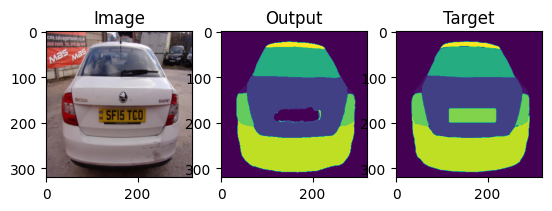

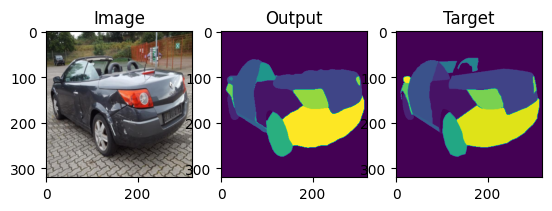

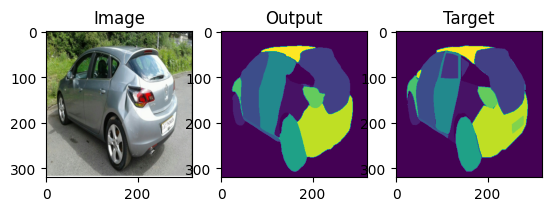

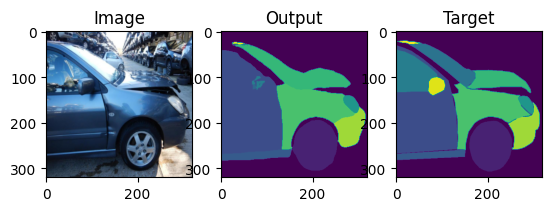

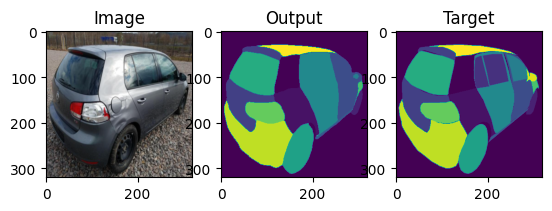

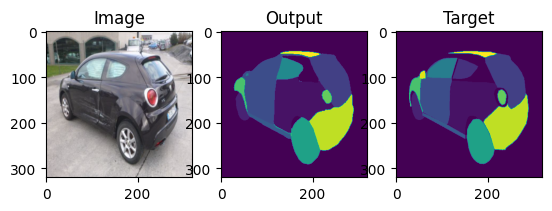

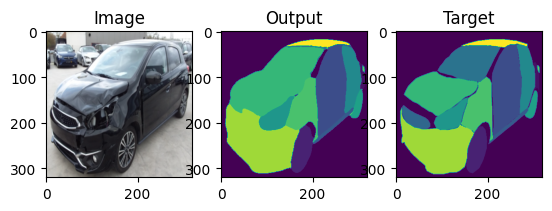

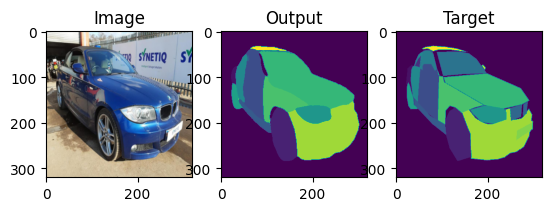

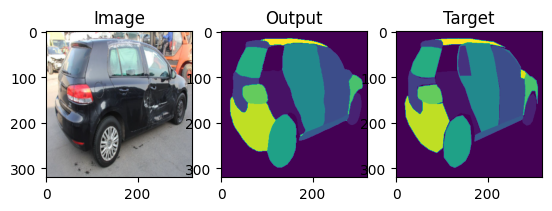

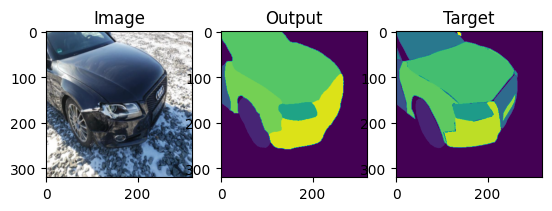

In [121]:
for i in range(10):
    x = random.randrange(1,len(CarPartsData))
    output1 = model(CarPartsData[x][0].unsqueeze(0).to('cuda'))
    image_viz = CarPartsData[x][0].cpu()
    output1 = output1.squeeze(0).detach().cpu()
    target = CarPartsData[x][1].squeeze(0).argmax(dim=0)
    full_mask = output1.argmax(dim=0)
    visualizeImageandMasks(image_viz.permute(1,2,0),full_mask,target)
    plt.show()


## Model Results for Car Parts Identification
The IOU (Intersection over Union) score is 0.86, which indicates that the model is able to accurately segment the objects in the images. An IOU score of 1.0 would indicate a perfect segmentation, so 0.86 is a good score.

The loss is 0.16, which is relatively low. Lower loss values indicate that the model is able to predict the correct class labels for the pixels in the images.

The validation loss is 0.20, which is slightly higher than the training loss. This is expected, as the validation set is not seen by the model during training, so it's a good indicator of how well the model will perform on unseen data.

The IOU score on the validation set is 0.86, which is the same as the training set. This indicates that the model is able to generalize well to unseen data.

Overall, the model seems to have performed well on both the training and validation sets.

## Car Damage Detection

In [141]:
cardamages_imgs = "/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/img/"
cardamages_anns = "/kaggle/input/car-parts-and-car-damages/Car parts dataset/File1/ann/"
sizes=(320,320)

In [142]:
CarDamagesClasses,CarDamagesClasses_ID = retrieve_meta_data("/kaggle/input/car-parts-and-car-damages/Car parts dataset/meta.json")

In [143]:
CarDamagesData =  CarDataLoader(transform,cardamages_imgs,cardamages_anns,CarDamagesClasses_ID,sizes)

In [144]:
image,mask = CarDamagesData[0]

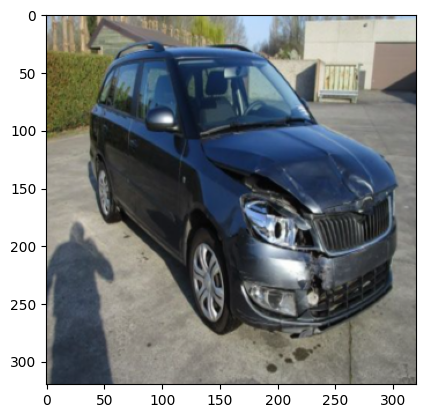

In [145]:
plt.imshow(image.squeeze(0).permute(1,2,0))

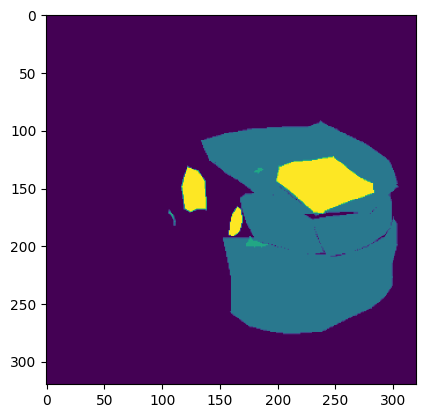

In [146]:
plt.imshow(mask.squeeze(0).argmax(dim=0))

In [148]:
print(len(CarDamagesClasses_ID)+1)

9


In [149]:
damagedataloader = DataLoader(CarDamagesData,batch_size=20,shuffle=True)


## Jaccard Loss

Jaccard loss, also known as Intersection over Union (IoU), is another loss function used to evaluate the performance of a semantic segmentation model. It is defined as the size of the intersection divided by the size of the union of two datasets: TP / (TP + FP + FN). Like Dice loss, Jaccard loss is a measure of dissimilarity between two datasets, and it ranges from 0 (denoting total dissimilarity) to 1 (denoting perfect similarity).

In [156]:
learning_rate = 0.0001
epochs = 30

# Model, Loss, and Optimizer
model_damages = MAnet(classes = len(CarDamagesClasses_ID)+1,encoder_weights="imagenet")
model_damages.to(device)
criterion_damages = JaccardLoss(classes = len(CarDamagesClasses_ID)+1,mode="multilabel")

optimizer_damages = torch.optim.Adam(model_damages.parameters(), lr=learning_rate)

TrainandValidate(model_damages,optimizer_damages,criterion_damages,damagedataloader,learning_rate,epochs,"MAnet_damages",classes = len(CarDamagesClasses_ID)+1)


Epoch 1/30:  90%|█████████ | 37/41 [00:44<00:04,  1.17s/it, iou_score=0.0105, loss=0.95]  

 Epoch under Validation 36, Loss: 0.8377575278282166, IOUScore 0.008326880633831024


Epoch 1/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.09s/it, iou_score=0.0105, loss=0.95]

 Epoch under Validation 37, Loss: 0.9498181939125061, IOUScore 0.01128812413662672


Epoch 1/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.06s/it, iou_score=0.0105, loss=0.95]

 Epoch under Validation 38, Loss: 0.9502819180488586, IOUScore 0.007453455589711666


Epoch 1/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.02s/it, iou_score=0.0105, loss=0.95]

 Epoch under Validation 39, Loss: 0.8394062519073486, IOUScore 0.007499148603528738


Epoch 1/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0105, loss=0.95]

 Epoch under Validation 40, Loss: 0.9492990970611572, IOUScore 0.007280826568603516



Epoch 2/30:  90%|█████████ | 37/41 [00:44<00:04,  1.16s/it, iou_score=0.0112, loss=0.95]  

 Epoch under Validation 36, Loss: 0.9500410556793213, IOUScore 0.012551959604024887


Epoch 2/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.07s/it, iou_score=0.0112, loss=0.95]

 Epoch under Validation 37, Loss: 0.9509410858154297, IOUScore 0.010330615565180779


Epoch 2/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.03s/it, iou_score=0.0112, loss=0.95]

 Epoch under Validation 38, Loss: 0.9501252770423889, IOUScore 0.009466423653066158


Epoch 2/30:  98%|█████████▊| 40/41 [00:47<00:00,  1.03it/s, iou_score=0.0112, loss=0.95]

 Epoch under Validation 39, Loss: 0.9508292078971863, IOUScore 0.010551776736974716


Epoch 2/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0112, loss=0.95]


 Epoch under Validation 40, Loss: 0.9486914873123169, IOUScore 0.009034285321831703


Epoch 3/30:  90%|█████████ | 37/41 [00:44<00:04,  1.23s/it, iou_score=0.0101, loss=0.949] 

 Epoch under Validation 36, Loss: 0.9485309720039368, IOUScore 0.011479864828288555


Epoch 3/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.18s/it, iou_score=0.0101, loss=0.949]

 Epoch under Validation 37, Loss: 0.9488048553466797, IOUScore 0.012682479806244373


Epoch 3/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.12s/it, iou_score=0.0101, loss=0.949]

 Epoch under Validation 38, Loss: 0.9509764909744263, IOUScore 0.0082393828779459


Epoch 3/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.10s/it, iou_score=0.0101, loss=0.949]

 Epoch under Validation 39, Loss: 0.9480001926422119, IOUScore 0.010755641385912895


Epoch 3/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0101, loss=0.949]


 Epoch under Validation 40, Loss: 0.9493785500526428, IOUScore 0.012258018366992474


Epoch 4/30:  90%|█████████ | 37/41 [00:43<00:04,  1.14s/it, iou_score=0.01, loss=0.839]   

 Epoch under Validation 36, Loss: 0.9489591717720032, IOUScore 0.01267758198082447


Epoch 4/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.14s/it, iou_score=0.01, loss=0.839]

 Epoch under Validation 37, Loss: 0.9485781192779541, IOUScore 0.013553098775446415


Epoch 4/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.17s/it, iou_score=0.01, loss=0.839]

 Epoch under Validation 38, Loss: 0.9486812949180603, IOUScore 0.009326381608843803


Epoch 4/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.14s/it, iou_score=0.01, loss=0.839]

 Epoch under Validation 39, Loss: 0.9494391679763794, IOUScore 0.011288984678685665


Epoch 4/30: 100%|██████████| 41/41 [00:48<00:00,  1.17s/it, iou_score=0.01, loss=0.839]


 Epoch under Validation 40, Loss: 0.9491108059883118, IOUScore 0.009798979386687279


Epoch 5/30:  90%|█████████ | 37/41 [00:43<00:04,  1.13s/it, iou_score=0.00992, loss=0.951]

 Epoch under Validation 36, Loss: 0.9486671090126038, IOUScore 0.012688710354268551


Epoch 5/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.11s/it, iou_score=0.00992, loss=0.951]

 Epoch under Validation 37, Loss: 0.9496616721153259, IOUScore 0.009287736378610134


Epoch 5/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.08s/it, iou_score=0.00992, loss=0.951]

 Epoch under Validation 38, Loss: 0.9484784007072449, IOUScore 0.013529308140277863


Epoch 5/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.09s/it, iou_score=0.00992, loss=0.951]

 Epoch under Validation 39, Loss: 0.9484856724739075, IOUScore 0.009821521118283272


Epoch 5/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.00992, loss=0.951]


 Epoch under Validation 40, Loss: 0.9493616223335266, IOUScore 0.01655449904501438


Epoch 6/30:  90%|█████████ | 37/41 [00:43<00:04,  1.17s/it, iou_score=0.011, loss=0.95]   

 Epoch under Validation 36, Loss: 0.9504733681678772, IOUScore 0.010671485215425491


Epoch 6/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.15s/it, iou_score=0.011, loss=0.95]

 Epoch under Validation 37, Loss: 0.9492456912994385, IOUScore 0.011417362838983536


Epoch 6/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.13s/it, iou_score=0.011, loss=0.95]

 Epoch under Validation 38, Loss: 0.9497656226158142, IOUScore 0.0075225564651191235


Epoch 6/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.14s/it, iou_score=0.011, loss=0.95]

 Epoch under Validation 39, Loss: 0.9478760957717896, IOUScore 0.01158291194587946


Epoch 6/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.011, loss=0.95]


 Epoch under Validation 40, Loss: 0.9457231163978577, IOUScore 0.009723672643303871


Epoch 7/30:  90%|█████████ | 37/41 [00:43<00:04,  1.11s/it, iou_score=0.00944, loss=0.951]

 Epoch under Validation 36, Loss: 0.9483845829963684, IOUScore 0.010117176920175552


Epoch 7/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.15s/it, iou_score=0.00944, loss=0.951]

 Epoch under Validation 37, Loss: 0.9470829367637634, IOUScore 0.013648548163473606


Epoch 7/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.13s/it, iou_score=0.00944, loss=0.951]

 Epoch under Validation 38, Loss: 0.9479571580886841, IOUScore 0.011655833572149277


Epoch 7/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.09s/it, iou_score=0.00944, loss=0.951]

 Epoch under Validation 39, Loss: 0.9500703811645508, IOUScore 0.010177290998399258


Epoch 7/30: 100%|██████████| 41/41 [00:48<00:00,  1.17s/it, iou_score=0.00944, loss=0.951]


 Epoch under Validation 40, Loss: 0.9486398696899414, IOUScore 0.012180740013718605


Epoch 8/30:  90%|█████████ | 37/41 [00:44<00:04,  1.07s/it, iou_score=0.0107, loss=0.95]  

 Epoch under Validation 36, Loss: 0.9500688910484314, IOUScore 0.010293692350387573


Epoch 8/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.04s/it, iou_score=0.0107, loss=0.95]

 Epoch under Validation 37, Loss: 0.9487532377243042, IOUScore 0.011592969298362732


Epoch 8/30:  95%|█████████▌| 39/41 [00:46<00:01,  1.01it/s, iou_score=0.0107, loss=0.95]

 Epoch under Validation 38, Loss: 0.9513266086578369, IOUScore 0.010247969999909401


Epoch 8/30:  98%|█████████▊| 40/41 [00:47<00:00,  1.00it/s, iou_score=0.0107, loss=0.95]

 Epoch under Validation 39, Loss: 0.9480507969856262, IOUScore 0.01504279114305973


Epoch 8/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0107, loss=0.95]


 Epoch under Validation 40, Loss: 0.8396076560020447, IOUScore 0.009650562889873981


Epoch 9/30:  90%|█████████ | 37/41 [00:44<00:04,  1.20s/it, iou_score=0.00965, loss=0.949]

 Epoch under Validation 36, Loss: 0.9490053653717041, IOUScore 0.010335591621696949


Epoch 9/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.10s/it, iou_score=0.00965, loss=0.949]

 Epoch under Validation 37, Loss: 0.9494921565055847, IOUScore 0.011005887761712074


Epoch 9/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.08s/it, iou_score=0.00965, loss=0.949]

 Epoch under Validation 38, Loss: 0.949433445930481, IOUScore 0.008822878822684288


Epoch 9/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.06s/it, iou_score=0.00965, loss=0.949]

 Epoch under Validation 39, Loss: 0.9494641423225403, IOUScore 0.008479519747197628


Epoch 9/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.00965, loss=0.949]


 Epoch under Validation 40, Loss: 0.8380404710769653, IOUScore 0.010275165550410748


Epoch 10/30:  90%|█████████ | 37/41 [00:44<00:04,  1.13s/it, iou_score=0.0095, loss=0.948] 

 Epoch under Validation 36, Loss: 0.9508673548698425, IOUScore 0.009316995739936829


Epoch 10/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.09s/it, iou_score=0.0095, loss=0.948]

 Epoch under Validation 37, Loss: 0.9493417739868164, IOUScore 0.011656656861305237


Epoch 10/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.07s/it, iou_score=0.0095, loss=0.948]

 Epoch under Validation 38, Loss: 0.9480258226394653, IOUScore 0.012787056155502796


Epoch 10/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.03s/it, iou_score=0.0095, loss=0.948]

 Epoch under Validation 39, Loss: 0.9500201344490051, IOUScore 0.01099458709359169


Epoch 10/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0095, loss=0.948]


 Epoch under Validation 40, Loss: 0.9504624605178833, IOUScore 0.008267415687441826


Epoch 11/30:  90%|█████████ | 37/41 [00:43<00:04,  1.18s/it, iou_score=0.0108, loss=0.95]  

 Epoch under Validation 36, Loss: 0.9475578665733337, IOUScore 0.011940954253077507


Epoch 11/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.16s/it, iou_score=0.0108, loss=0.95]

 Epoch under Validation 37, Loss: 0.9486855268478394, IOUScore 0.010629596188664436


Epoch 11/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.10s/it, iou_score=0.0108, loss=0.95]

 Epoch under Validation 38, Loss: 0.9513323307037354, IOUScore 0.009768563322722912


Epoch 11/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.11s/it, iou_score=0.0108, loss=0.95]

 Epoch under Validation 39, Loss: 0.9481435418128967, IOUScore 0.013077463954687119


Epoch 11/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0108, loss=0.95]

 Epoch under Validation 40, Loss: 0.9470041394233704, IOUScore 0.01618695631623268



Epoch 12/30:  90%|█████████ | 37/41 [00:44<00:04,  1.14s/it, iou_score=0.00948, loss=0.95] 

 Epoch under Validation 36, Loss: 0.9509595036506653, IOUScore 0.00808305200189352


Epoch 12/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.11s/it, iou_score=0.00948, loss=0.95]

 Epoch under Validation 37, Loss: 0.9487842917442322, IOUScore 0.010644732043147087


Epoch 12/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.06s/it, iou_score=0.00948, loss=0.95]

 Epoch under Validation 38, Loss: 0.951099693775177, IOUScore 0.009625362232327461


Epoch 12/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.04s/it, iou_score=0.00948, loss=0.95]

 Epoch under Validation 39, Loss: 0.9485461115837097, IOUScore 0.009880387224256992


Epoch 12/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.00948, loss=0.95]


 Epoch under Validation 40, Loss: 0.950043797492981, IOUScore 0.009089321829378605


Epoch 13/30:  90%|█████████ | 37/41 [00:44<00:04,  1.24s/it, iou_score=0.00993, loss=0.948]

 Epoch under Validation 36, Loss: 0.9465851187705994, IOUScore 0.014607563614845276


Epoch 13/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.13s/it, iou_score=0.00993, loss=0.948]

 Epoch under Validation 37, Loss: 0.95084148645401, IOUScore 0.012480983510613441


Epoch 13/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.07s/it, iou_score=0.00993, loss=0.948]

 Epoch under Validation 38, Loss: 0.9504203796386719, IOUScore 0.01095004566013813


Epoch 13/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.03s/it, iou_score=0.00993, loss=0.948]

 Epoch under Validation 39, Loss: 0.9502508640289307, IOUScore 0.010209182277321815


Epoch 13/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.00993, loss=0.948]


 Epoch under Validation 40, Loss: 0.9495097398757935, IOUScore 0.011137455701828003


Epoch 14/30:  90%|█████████ | 37/41 [00:43<00:04,  1.20s/it, iou_score=0.00997, loss=0.949]

 Epoch under Validation 36, Loss: 0.9498801827430725, IOUScore 0.011053210124373436


Epoch 14/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.22s/it, iou_score=0.00997, loss=0.949]

 Epoch under Validation 37, Loss: 0.9457820057868958, IOUScore 0.011322114616632462


Epoch 14/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.14s/it, iou_score=0.00997, loss=0.949]

 Epoch under Validation 38, Loss: 0.949711263179779, IOUScore 0.012490419670939445


Epoch 14/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.07s/it, iou_score=0.00997, loss=0.949]

 Epoch under Validation 39, Loss: 0.949601948261261, IOUScore 0.01056917104870081


Epoch 14/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.00997, loss=0.949]


 Epoch under Validation 40, Loss: 0.9502785801887512, IOUScore 0.012007581070065498


Epoch 15/30:  90%|█████████ | 37/41 [00:43<00:04,  1.12s/it, iou_score=0.0108, loss=0.95]  

 Epoch under Validation 36, Loss: 0.9493597745895386, IOUScore 0.009938692674040794


Epoch 15/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.11s/it, iou_score=0.0108, loss=0.95]

 Epoch under Validation 37, Loss: 0.9493566155433655, IOUScore 0.01035222876816988


Epoch 15/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.09s/it, iou_score=0.0108, loss=0.95]

 Epoch under Validation 38, Loss: 0.948553204536438, IOUScore 0.011469131335616112


Epoch 15/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.06s/it, iou_score=0.0108, loss=0.95]

 Epoch under Validation 39, Loss: 0.9485502243041992, IOUScore 0.011357973329722881


Epoch 15/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0108, loss=0.95]


 Epoch under Validation 40, Loss: 0.9476657509803772, IOUScore 0.011212334036827087


Epoch 16/30:  90%|█████████ | 37/41 [00:43<00:04,  1.17s/it, iou_score=0.0109, loss=0.947] 

 Epoch under Validation 36, Loss: 0.9518800377845764, IOUScore 0.009761115536093712


Epoch 16/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.15s/it, iou_score=0.0109, loss=0.947]

 Epoch under Validation 37, Loss: 0.946489155292511, IOUScore 0.00997111015021801


Epoch 16/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.10s/it, iou_score=0.0109, loss=0.947]

 Epoch under Validation 38, Loss: 0.9479399919509888, IOUScore 0.012609143741428852


Epoch 16/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.09s/it, iou_score=0.0109, loss=0.947]

 Epoch under Validation 39, Loss: 0.9480665922164917, IOUScore 0.007589652203023434


Epoch 16/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0109, loss=0.947]


 Epoch under Validation 40, Loss: 0.9514330625534058, IOUScore 0.01075009349733591


Epoch 17/30:  90%|█████████ | 37/41 [00:44<00:04,  1.10s/it, iou_score=0.0111, loss=0.952] 

 Epoch under Validation 36, Loss: 0.9502156376838684, IOUScore 0.01178382895886898


Epoch 17/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.03s/it, iou_score=0.0111, loss=0.952]

 Epoch under Validation 37, Loss: 0.9506704807281494, IOUScore 0.011860574595630169


Epoch 17/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.07s/it, iou_score=0.0111, loss=0.952]

 Epoch under Validation 38, Loss: 0.8369418382644653, IOUScore 0.011995538137853146


Epoch 17/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.04s/it, iou_score=0.0111, loss=0.952]

 Epoch under Validation 39, Loss: 0.9501469135284424, IOUScore 0.008131464011967182


Epoch 17/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0111, loss=0.952]


 Epoch under Validation 40, Loss: 0.8370252251625061, IOUScore 0.012789818458259106


Epoch 18/30:  90%|█████████ | 37/41 [00:43<00:04,  1.14s/it, iou_score=0.0107, loss=0.949] 

 Epoch under Validation 36, Loss: 0.9498527646064758, IOUScore 0.009696823544800282


Epoch 18/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.17s/it, iou_score=0.0107, loss=0.949]

 Epoch under Validation 37, Loss: 0.9461928606033325, IOUScore 0.010376798920333385


Epoch 18/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.11s/it, iou_score=0.0107, loss=0.949]

 Epoch under Validation 38, Loss: 0.9492636919021606, IOUScore 0.012725367210805416


Epoch 18/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.08s/it, iou_score=0.0107, loss=0.949]

 Epoch under Validation 39, Loss: 0.9503714442253113, IOUScore 0.008877771906554699


Epoch 18/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0107, loss=0.949]


 Epoch under Validation 40, Loss: 0.9497255682945251, IOUScore 0.008325900882482529


Epoch 19/30:  90%|█████████ | 37/41 [00:43<00:04,  1.13s/it, iou_score=0.0116, loss=0.949] 

 Epoch under Validation 36, Loss: 0.9493811130523682, IOUScore 0.011060567572712898


Epoch 19/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.10s/it, iou_score=0.0116, loss=0.949]

 Epoch under Validation 37, Loss: 0.9488597512245178, IOUScore 0.009436827152967453


Epoch 19/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.02s/it, iou_score=0.0116, loss=0.949]

 Epoch under Validation 38, Loss: 0.9519271850585938, IOUScore 0.011832292191684246


Epoch 19/30:  98%|█████████▊| 40/41 [00:46<00:00,  1.00it/s, iou_score=0.0116, loss=0.949]

 Epoch under Validation 39, Loss: 0.9497584104537964, IOUScore 0.009617368690669537


Epoch 19/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0116, loss=0.949]


 Epoch under Validation 40, Loss: 0.948201060295105, IOUScore 0.009488602168858051


Epoch 20/30:  90%|█████████ | 37/41 [00:43<00:04,  1.12s/it, iou_score=0.0106, loss=0.95]  

 Epoch under Validation 36, Loss: 0.9477382302284241, IOUScore 0.012646248564124107


Epoch 20/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.07s/it, iou_score=0.0106, loss=0.95]

 Epoch under Validation 37, Loss: 0.9501552581787109, IOUScore 0.008027395233511925


Epoch 20/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.11s/it, iou_score=0.0106, loss=0.95]

 Epoch under Validation 38, Loss: 0.9467090964317322, IOUScore 0.010478437878191471


Epoch 20/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.08s/it, iou_score=0.0106, loss=0.95]

 Epoch under Validation 39, Loss: 0.9504254460334778, IOUScore 0.010052330791950226


Epoch 20/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0106, loss=0.95]


 Epoch under Validation 40, Loss: 0.9491664171218872, IOUScore 0.01479873713105917


Epoch 21/30:  90%|█████████ | 37/41 [00:44<00:04,  1.20s/it, iou_score=0.00941, loss=0.949]

 Epoch under Validation 36, Loss: 0.94859379529953, IOUScore 0.012473463080823421


Epoch 21/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.10s/it, iou_score=0.00941, loss=0.949]

 Epoch under Validation 37, Loss: 0.8397310972213745, IOUScore 0.012965650297701359


Epoch 21/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.09s/it, iou_score=0.00941, loss=0.949]

 Epoch under Validation 38, Loss: 0.9500572681427002, IOUScore 0.013237521052360535


Epoch 21/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.01s/it, iou_score=0.00941, loss=0.949]

 Epoch under Validation 39, Loss: 0.9523094892501831, IOUScore 0.01027052290737629


Epoch 21/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.00941, loss=0.949]

 Epoch under Validation 40, Loss: 0.9502542614936829, IOUScore 0.012746228836476803



Epoch 22/30:  90%|█████████ | 37/41 [00:43<00:04,  1.10s/it, iou_score=0.0102, loss=0.949] 

 Epoch under Validation 36, Loss: 0.950113832950592, IOUScore 0.009302153252065182


Epoch 22/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.04s/it, iou_score=0.0102, loss=0.949]

 Epoch under Validation 37, Loss: 0.9512233734130859, IOUScore 0.011305119842290878


Epoch 22/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.04s/it, iou_score=0.0102, loss=0.949]

 Epoch under Validation 38, Loss: 0.9495784044265747, IOUScore 0.010223877616226673


Epoch 22/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.06s/it, iou_score=0.0102, loss=0.949]

 Epoch under Validation 39, Loss: 0.9495686292648315, IOUScore 0.011470513418316841


Epoch 22/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0102, loss=0.949]


 Epoch under Validation 40, Loss: 0.9445374608039856, IOUScore 0.013535474427044392


Epoch 23/30:  90%|█████████ | 37/41 [00:44<00:04,  1.08s/it, iou_score=0.0101, loss=0.95]  

 Epoch under Validation 36, Loss: 0.9499374032020569, IOUScore 0.009742425754666328


Epoch 23/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.07s/it, iou_score=0.0101, loss=0.95]

 Epoch under Validation 37, Loss: 0.9508849382400513, IOUScore 0.009519675746560097


Epoch 23/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.09s/it, iou_score=0.0101, loss=0.95]

 Epoch under Validation 38, Loss: 0.9478448033332825, IOUScore 0.011920827440917492


Epoch 23/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.07s/it, iou_score=0.0101, loss=0.95]

 Epoch under Validation 39, Loss: 0.9480476379394531, IOUScore 0.01275742519646883


Epoch 23/30: 100%|██████████| 41/41 [00:48<00:00,  1.17s/it, iou_score=0.0101, loss=0.95]


 Epoch under Validation 40, Loss: 0.949747622013092, IOUScore 0.011551073752343655


Epoch 24/30:  90%|█████████ | 37/41 [00:44<00:04,  1.17s/it, iou_score=0.009, loss=0.951]  

 Epoch under Validation 36, Loss: 0.9482981562614441, IOUScore 0.010600853711366653


Epoch 24/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.12s/it, iou_score=0.009, loss=0.951]

 Epoch under Validation 37, Loss: 0.949524998664856, IOUScore 0.00987931527197361


Epoch 24/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.08s/it, iou_score=0.009, loss=0.951]

 Epoch under Validation 38, Loss: 0.9500232338905334, IOUScore 0.008720935322344303


Epoch 24/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.01s/it, iou_score=0.009, loss=0.951]

 Epoch under Validation 39, Loss: 0.9500244855880737, IOUScore 0.008633472956717014


Epoch 24/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.009, loss=0.951]


 Epoch under Validation 40, Loss: 0.9487783908843994, IOUScore 0.009973335079848766


Epoch 25/30:  90%|█████████ | 37/41 [00:43<00:04,  1.10s/it, iou_score=0.00946, loss=0.951]

 Epoch under Validation 36, Loss: 0.9487898349761963, IOUScore 0.012437216006219387


Epoch 25/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.04s/it, iou_score=0.00946, loss=0.951]

 Epoch under Validation 37, Loss: 0.9486954808235168, IOUScore 0.012146050110459328


Epoch 25/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.00s/it, iou_score=0.00946, loss=0.951]

 Epoch under Validation 38, Loss: 0.9501752853393555, IOUScore 0.011526981368660927


Epoch 25/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.04s/it, iou_score=0.00946, loss=0.951]

 Epoch under Validation 39, Loss: 0.9479541778564453, IOUScore 0.01511369738727808


Epoch 25/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.00946, loss=0.951]


 Epoch under Validation 40, Loss: 0.9494319558143616, IOUScore 0.011567185632884502


Epoch 26/30:  90%|█████████ | 37/41 [00:44<00:05,  1.25s/it, iou_score=0.00982, loss=0.949]

 Epoch under Validation 36, Loss: 0.9482012987136841, IOUScore 0.01281703170388937


Epoch 26/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.16s/it, iou_score=0.00982, loss=0.949]

 Epoch under Validation 37, Loss: 0.9509701132774353, IOUScore 0.01008077897131443


Epoch 26/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.15s/it, iou_score=0.00982, loss=0.949]

 Epoch under Validation 38, Loss: 0.9500559568405151, IOUScore 0.01065137144178152


Epoch 26/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.11s/it, iou_score=0.00982, loss=0.949]

 Epoch under Validation 39, Loss: 0.9487227201461792, IOUScore 0.008734317496418953


Epoch 26/30: 100%|██████████| 41/41 [00:48<00:00,  1.19s/it, iou_score=0.00982, loss=0.949]


 Epoch under Validation 40, Loss: 0.949341893196106, IOUScore 0.012267942540347576


Epoch 27/30:  90%|█████████ | 37/41 [00:43<00:04,  1.18s/it, iou_score=0.00952, loss=0.948]

 Epoch under Validation 36, Loss: 0.9479662775993347, IOUScore 0.011192385107278824


Epoch 27/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.10s/it, iou_score=0.00952, loss=0.948]

 Epoch under Validation 37, Loss: 0.9500196576118469, IOUScore 0.012334425933659077


Epoch 27/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.14s/it, iou_score=0.00952, loss=0.948]

 Epoch under Validation 38, Loss: 0.9457507729530334, IOUScore 0.011374431662261486


Epoch 27/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.04s/it, iou_score=0.00952, loss=0.948]

 Epoch under Validation 39, Loss: 0.9511436820030212, IOUScore 0.011951448395848274


Epoch 27/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.00952, loss=0.948]


 Epoch under Validation 40, Loss: 0.9493487477302551, IOUScore 0.010206361301243305


Epoch 28/30:  90%|█████████ | 37/41 [00:43<00:04,  1.17s/it, iou_score=0.0107, loss=0.949] 

 Epoch under Validation 36, Loss: 0.9497000575065613, IOUScore 0.009744564071297646


Epoch 28/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.13s/it, iou_score=0.0107, loss=0.949]

 Epoch under Validation 37, Loss: 0.9497891664505005, IOUScore 0.010754437185823917


Epoch 28/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.18s/it, iou_score=0.0107, loss=0.949]

 Epoch under Validation 38, Loss: 0.9452469944953918, IOUScore 0.012263724580407143


Epoch 28/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.11s/it, iou_score=0.0107, loss=0.949]

 Epoch under Validation 39, Loss: 0.9493923187255859, IOUScore 0.014413634315133095


Epoch 28/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0107, loss=0.949]


 Epoch under Validation 40, Loss: 0.9464250206947327, IOUScore 0.010157613083720207


Epoch 29/30:  90%|█████████ | 37/41 [00:43<00:04,  1.20s/it, iou_score=0.0114, loss=0.947] 

 Epoch under Validation 36, Loss: 0.9485199451446533, IOUScore 0.010161728598177433


Epoch 29/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.16s/it, iou_score=0.0114, loss=0.947]

 Epoch under Validation 37, Loss: 0.94676673412323, IOUScore 0.013154054991900921


Epoch 29/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.10s/it, iou_score=0.0114, loss=0.947]

 Epoch under Validation 38, Loss: 0.8386279344558716, IOUScore 0.011580104008316994


Epoch 29/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.05s/it, iou_score=0.0114, loss=0.947]

 Epoch under Validation 39, Loss: 0.8394185900688171, IOUScore 0.010383553802967072


Epoch 29/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0114, loss=0.947]


 Epoch under Validation 40, Loss: 0.949677586555481, IOUScore 0.009091326035559177


Epoch 30/30:  90%|█████████ | 37/41 [00:43<00:04,  1.16s/it, iou_score=0.0105, loss=0.839] 

 Epoch under Validation 36, Loss: 0.9463904500007629, IOUScore 0.012059534899890423


Epoch 30/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.12s/it, iou_score=0.0105, loss=0.839]

 Epoch under Validation 37, Loss: 0.8384613990783691, IOUScore 0.011978435330092907


Epoch 30/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.09s/it, iou_score=0.0105, loss=0.839]

 Epoch under Validation 38, Loss: 0.9495454430580139, IOUScore 0.011778950691223145


Epoch 30/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.03s/it, iou_score=0.0105, loss=0.839]

 Epoch under Validation 39, Loss: 0.9497981667518616, IOUScore 0.009492356330156326


Epoch 30/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0105, loss=0.839]

 Epoch under Validation 40, Loss: 0.9477632641792297, IOUScore 0.01188442949205637


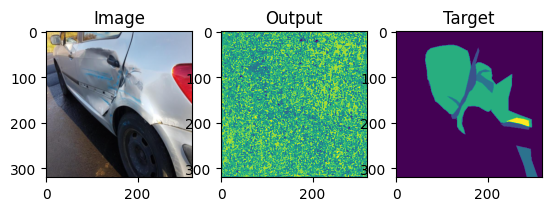

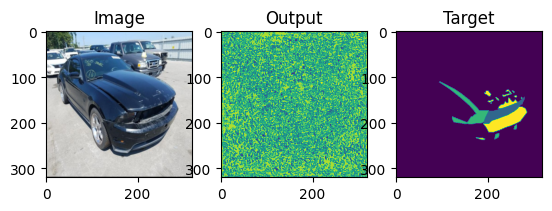

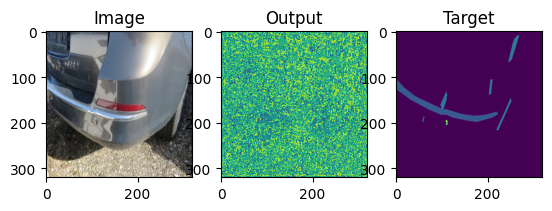

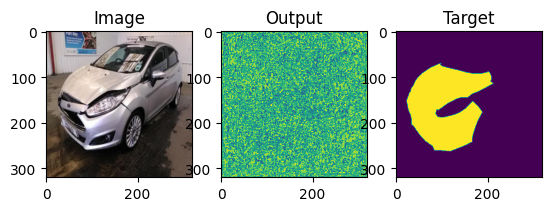

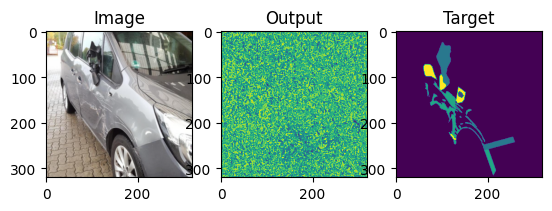

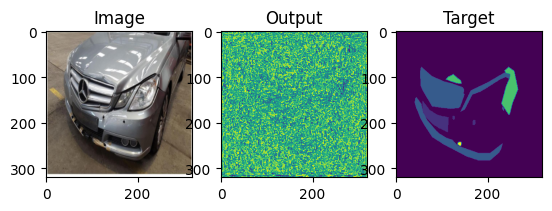

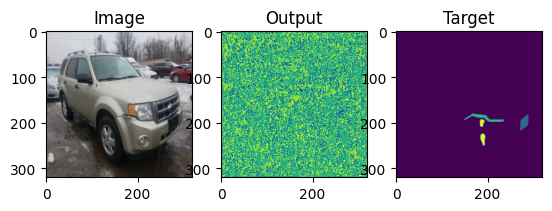

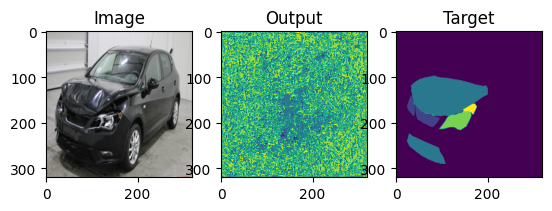

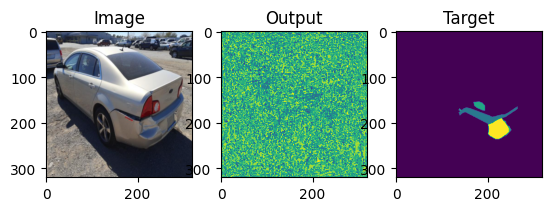

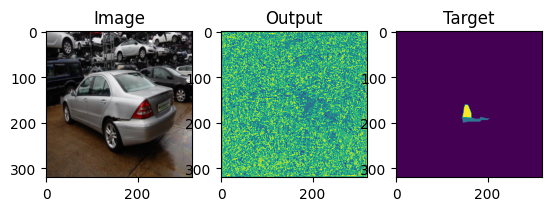

In [158]:
for i in range(10):
    x = random.randrange(1,len(CarDamagesData))
    output1 = model_damages(CarDamagesData[x][0].unsqueeze(0).to('cuda'))
    image_viz = CarDamagesData[x][0].cpu()
    output1 = output1.squeeze(0).detach().cpu()
    target = CarDamagesData[x][1].squeeze(0).argmax(dim=0)
    full_mask = output1.argmax(dim=0)
    visualizeImageandMasks(image_viz.permute(1,2,0),full_mask,target)
    plt.show()

In [157]:
torch.save({
                'epoch': 30,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"MANet Damages Model.pth")

# Trial 2 

With Dice Loss

In [ ]:
learning_rate = 0.0001
epochs = 30

# Model, Loss, and Optimizer
model_damages = MAnet(classes = len(CarDamagesClasses_ID)+1,encoder_weights="imagenet")
model_damages.to(device)
criterion_damages = DiceLoss(classes = len(CarDamagesClasses_ID)+1,mode="multilabel")

optimizer_damages = torch.optim.Adam(model_damages.parameters(), lr=learning_rate)

TrainandValidate(model_damages,optimizer_damages,criterion_damages,damagedataloader,learning_rate,epochs,"MAnet_damages",classes = len(CarDamagesClasses_ID)+1)


Epoch 1/30:  90%|█████████ | 37/41 [00:44<00:04,  1.16s/it, iou_score=0.0449, loss=0.906]

 Epoch under Validation 36, Loss: 0.7976654171943665, IOUScore 0.039498500525951385


Epoch 1/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.10s/it, iou_score=0.0449, loss=0.906]

 Epoch under Validation 37, Loss: 0.906711995601654, IOUScore 0.04459237679839134


Epoch 1/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.08s/it, iou_score=0.0449, loss=0.906]

 Epoch under Validation 38, Loss: 0.9099322557449341, IOUScore 0.040366966277360916


Epoch 1/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.01s/it, iou_score=0.0449, loss=0.906]

 Epoch under Validation 39, Loss: 0.9126821160316467, IOUScore 0.04200994223356247


Epoch 1/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0449, loss=0.906]

 Epoch under Validation 40, Loss: 0.9051294326782227, IOUScore 0.04387427866458893



Epoch 2/30:  90%|█████████ | 37/41 [00:43<00:04,  1.08s/it, iou_score=0.0419, loss=0.909]

 Epoch under Validation 36, Loss: 0.9100745320320129, IOUScore 0.043182097375392914


Epoch 2/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.08s/it, iou_score=0.0419, loss=0.909]

 Epoch under Validation 37, Loss: 0.9062491655349731, IOUScore 0.046573884785175323


Epoch 2/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.09s/it, iou_score=0.0419, loss=0.909]

 Epoch under Validation 38, Loss: 0.90998774766922, IOUScore 0.04068125784397125


Epoch 2/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.05s/it, iou_score=0.0419, loss=0.909]

 Epoch under Validation 39, Loss: 0.9106036424636841, IOUScore 0.042014963924884796


Epoch 2/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0419, loss=0.909]


 Epoch under Validation 40, Loss: 0.9094054102897644, IOUScore 0.047692347317934036


Epoch 3/30:  90%|█████████ | 37/41 [00:43<00:04,  1.10s/it, iou_score=0.0428, loss=0.909]

 Epoch under Validation 36, Loss: 0.9088780283927917, IOUScore 0.04205155000090599


Epoch 3/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.09s/it, iou_score=0.0428, loss=0.909]

 Epoch under Validation 37, Loss: 0.9064591526985168, IOUScore 0.04659926891326904


Epoch 3/30:  95%|█████████▌| 39/41 [00:46<00:02,  1.06s/it, iou_score=0.0428, loss=0.909]

 Epoch under Validation 38, Loss: 0.9065784811973572, IOUScore 0.043575458228588104


Epoch 3/30:  98%|█████████▊| 40/41 [00:46<00:01,  1.03s/it, iou_score=0.0428, loss=0.909]

 Epoch under Validation 39, Loss: 0.9074404239654541, IOUScore 0.04398095980286598


Epoch 3/30: 100%|██████████| 41/41 [00:47<00:00,  1.16s/it, iou_score=0.0428, loss=0.909]


 Epoch under Validation 40, Loss: 0.8005907535552979, IOUScore 0.046694543212652206


Epoch 4/30:  90%|█████████ | 37/41 [00:43<00:04,  1.12s/it, iou_score=0.0436, loss=0.797]

 Epoch under Validation 36, Loss: 0.9121968150138855, IOUScore 0.04374519735574722


Epoch 4/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.03s/it, iou_score=0.0436, loss=0.797]

 Epoch under Validation 37, Loss: 0.9143498539924622, IOUScore 0.04539966583251953


Epoch 4/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.01s/it, iou_score=0.0436, loss=0.797]

 Epoch under Validation 38, Loss: 0.9090803861618042, IOUScore 0.045305926352739334


Epoch 4/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.13s/it, iou_score=0.0436, loss=0.797]

 Epoch under Validation 39, Loss: 0.9017517566680908, IOUScore 0.043758414685726166


Epoch 4/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0436, loss=0.797]


 Epoch under Validation 40, Loss: 0.9059385657310486, IOUScore 0.046559326350688934


Epoch 5/30:  90%|█████████ | 37/41 [00:44<00:04,  1.16s/it, iou_score=0.0441, loss=0.912]

 Epoch under Validation 36, Loss: 0.9125924706459045, IOUScore 0.04259404540061951


Epoch 5/30:  93%|█████████▎| 38/41 [00:45<00:03,  1.12s/it, iou_score=0.0441, loss=0.912]

 Epoch under Validation 37, Loss: 0.9088841676712036, IOUScore 0.045549362897872925


Epoch 5/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.05s/it, iou_score=0.0441, loss=0.912]

 Epoch under Validation 38, Loss: 0.9108559489250183, IOUScore 0.047462403774261475


Epoch 5/30:  98%|█████████▊| 40/41 [00:47<00:01,  1.07s/it, iou_score=0.0441, loss=0.912]

 Epoch under Validation 39, Loss: 0.907215416431427, IOUScore 0.041923049837350845


Epoch 5/30: 100%|██████████| 41/41 [00:47<00:00,  1.17s/it, iou_score=0.0441, loss=0.912]


 Epoch under Validation 40, Loss: 0.9049036502838135, IOUScore 0.04721805825829506


Epoch 6/30:  90%|█████████ | 37/41 [00:43<00:05,  1.26s/it, iou_score=0.045, loss=0.901] 

 Epoch under Validation 36, Loss: 0.9005057215690613, IOUScore 0.05093130096793175


Epoch 6/30:  93%|█████████▎| 38/41 [00:44<00:03,  1.20s/it, iou_score=0.045, loss=0.901]

 Epoch under Validation 37, Loss: 0.9090137481689453, IOUScore 0.045145004987716675


Epoch 6/30:  95%|█████████▌| 39/41 [00:45<00:02,  1.15s/it, iou_score=0.045, loss=0.901]